### Clear memory

In [1]:
%reset -f
import gc
gc.collect()

0

### Import 

In [ ]:
import sys, joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
sys.path.append('..')
from src.scripts.data_utils import TEPDataLoader, filter_csv, describe_dataframe
from src.scripts.eda_utils import (
    plot_sizes,
    plot_variability_analysis,
    plot_fault_comparison_timeseries,
    plot_mutual_info,
    plot_fault_comparison_boxplots,
    plot_correlation_matrix,
)

# Tennessee Eastman Process Dataset

## Overview

The Tennessee Eastman Process dataset is a widely-used benchmark for industrial process monitoring and fault detection. It simulates a chemical plant with multiple interconnected unit operations including reactors, separators, and recycle streams.

## Dataset Structure

| Column Type | Range | Count | Description |
|-------------|-------|-------|-------------|
| **Target Variable** | `faultNumber` | 1 | Fault identifier (0 = normal, 1-21 = specific fault types) |
| **Metadata** | `simulationRun` | 1 | Independent simulation run identifier |
| **Time Index** | `sample` | 1 | Temporal measurement index within each run |
| **Process Measurements** | `xmeas_1` to `xmeas_41` | 41 | Sensor readings (temperatures, pressures, flows, levels, compositions) |
| **Manipulated Variables** | `xmv_1` to `xmv_11` | 11 | Control variables (valve positions, pump speeds, controller setpoints) |

**Total Features:** 55 columns  
**Time Series:** Yes, sequential measurements over time  
**Fault Types:** 21 different fault scenarios plus normal operation

## Key Characteristics

- **Industrial Realism:** Models real chemical plant dynamics with realistic noise and process interactions
- **Temporal Dependencies:** Strong autocorrelations and cross-correlations between variables over time
- **Fault Diversity:** Covers sensor failures, process disturbances, and equipment malfunctions
- **Control System:** Includes automatic control responses that create complex feedback loops

## Usage Notes

- **faultNumber** should be excluded during unsupervised training and used only for evaluation
- **sample** provides crucial temporal ordering for time series analysis methods
- Variables exhibit non-normal distributions and significant cross-correlations
- Different fault types manifest with varying intensities and temporal patterns

## Data Splits

Typically organized into four files:
- Training normal (fault-free) operations
- Testing normal operations  
- Training faulty operations (multiple fault types)
- Testing faulty operations

This structure supports both unsupervised anomaly detection (using only normal training data) and supervised classification approaches (using both normal and faulty training data).

# Data Loading and Preprocessing

## Convert Raw Data to CSV Format
First, we convert the original dataset files to CSV format for easier processing.

In [ ]:
loader = TEPDataLoader(
    raw_data_path='../data/raw',
    processed_data_path='../data/processed',
)

loader.convert_and_save_to_csv()


## Dataset Reduction for Demonstration
For this portfolio project, we focus on demonstrating technical skills rather than achieving maximum accuracy. Therefore, we limit our analysis to:
- **3 fault types** (0, 1, 13, 16) out of 21 total faults (where 0 = normal operation)
- **50 simulations** out of 500 available simulations per fault type

This reduction allows for faster experimentation while still showcasing the methodology.

The selected fault types represent different categories of industrial failures:
- **Fault 0:** Normal operation
- **Fault 1:** A/C feed ratio, B composition constant (step change in stream 4)
- **Fault 13:** Reaction kinetics (slow drift)
- **Fault 16:** Unknown disturbances

This selection provides diverse anomaly patterns for detection algorithms.

In [ ]:
SELECTED_FAULTS = [0, 1, 13, 16]
MAX_SIMULATION = 50
files = ['TEP_fault_free_testing', 'TEP_fault_free_training', 'TEP_faulty_testing', 'TEP_faulty_training']

for f in files:
    filter_csv(f, SELECTED_FAULTS, MAX_SIMULATION, data_path='../data/processed')
    print(f'File {f} has been filtered and saved')

# Exploratory Data Analysis (EDA)

## Load Filtered Datasets
Load the pre-processed and filtered datasets for analysis.


In [7]:
df_fault_free_train = pd.read_csv('../data/processed/TEP_fault_free_training_filtered.csv')
df_fault_free_test = pd.read_csv('../data/processed/TEP_fault_free_testing_filtered.csv')

df_faulty_train = pd.read_csv('../data/processed/TEP_faulty_training_filtered.csv')
df_faulty_test = pd.read_csv('../data/processed/TEP_faulty_testing_filtered.csv')

## Basic Dataset Information
Let's examine the structure and properties of each dataset.

In [8]:
_ = describe_dataframe(df_fault_free_train)

First 5 rows of the DataFrame:


faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0            1.0       1  0.25038   3674.0   4529.0   9.2320   
1          0.0            1.0       2  0.25109   3659.4   4556.6   9.4264   
2          0.0            1.0       3  0.25038   3660.3   4477.8   9.4426   
3          0.0            1.0       4  0.24977   3661.3   4512.1   9.4776   
4          0.0            1.0       5  0.29405   3679.0   4497.0   9.3381   

   xmeas_5  xmeas_6  xmeas_7  xmeas_8  xmeas_9  xmeas_10  xmeas_11  xmeas_12  \
0   26.889   42.402   2704.3   74.863   120.41   0.33818    80.044    51.435   
1   26.721   42.576   2705.0   75.000   120.41   0.33620    80.078    50.154   
2   26.875   42.070   2706.2   74.771   120.42   0.33563    80.220    50.302   
3   26.758   42.063   2707.2   75.224   120.39   0.33553    80.305    49.990   
4   26.889   42.650   2705.1   75.388   120.39   0.32632    80.064    51.310   

   xmeas_13  xmeas_14  xmeas_15  xmeas_16  xmeas_17  xmeas_18  xmeas_19  \
0    2632.9    25.029    50.528    3101.1    22.819    65.732    229.61   
1    2633.8    24.419    48.772    3102.0    23.333    65.716    230.54   
2    2635.5    25.244    50.071    3103.5    21.924    65.732    230.08   
3    2635.6    23.268    50.435    3102.8    22.948    65.781    227.91   
4    2632.4    26.099    50.480    3103.5    22.808    65.788    231.37   

   xmeas_20  xmeas_21  xmeas_22  xmeas_23  xmeas_24  xmeas_25  xmeas_26  \
0    341.22    94.640    77.047    32.188    8.8933    26.383    6.8820   
1    341.30    94.595    77.434    32.188    8.8933    26.383    6.8820   
2    341.38    94.605    77.466    31.767    8.7694    26.095    6.8259   
3    341.71    94.473    77.443    31.767    8.7694    26.095    6.8259   
4    341.11    94.678    76.947    32.322    8.5821    26.769    6.8688   

   xmeas_27  xmeas_28  xmeas_29  xmeas_30  xmeas_31  xmeas_32  xmeas_33  \
0    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
1    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
2    18.961    1.6292    32.985    13.742    23.897    1.3001    18.765   
3    18.961    1.6292    32.985    13.742    23.897    1.3001    18.765   
4    18.782    1.6396    33.071    13.834    24.228    1.0938    18.666   

   xmeas_34  xmeas_35  xmeas_36  xmeas_37  xmeas_38  xmeas_39  xmeas_40  \
0    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
1    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
2    2.2602    4.8543    2.3900  0.017866    0.8357  0.098577    53.724   
3    2.2602    4.8543    2.3900  0.017866    0.8357  0.098577    53.724   
4    2.2193    4.8304    2.2416  0.017866    0.8357  0.098577    53.724   

   xmeas_41   xmv_1   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8  \
0    43.828  62.881  53.744  24.657  62.544  22.137  39.935  42.323  47.757   
1    43.828  63.132  53.414  24.588  59.259  22.084  40.176  38.554  43.692   
2    43.828  63.117  54.357  24.666  61.275  22.380  40.244  38.990  46.699   
3    43.828  63.100  53.946  24.725  59.856  22.277  40.257  38.072  47.541   
4    43.828  63.313  53.658  28.797  60.717  21.947  39.144  41.955  47.645   

    xmv_9  xmv_10  xmv_11  
0  47.510  41.258  18.447  
1  47.427  41.359  17.194  
2  47.468  41.199  20.530  
3  47.658  41.643  18.089  
4  47.346  41.507  18.461

________________________________________________________________________________

Shape of the DataFrame: (25000, 55)
________________________________________________________________________________

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   faultNumber    25000 non-null  float64
 1   simulationRun  25000 non-null  float64
 2   sample         25000 non-null  int64  
 3   xmeas_1        25000 non-null  float64
 4   xmeas_2        25000 non-null  float64
 5   xmeas_3        25000 non-null  float64
 6   xmeas_4        25000 non-null  float64
 7   xmeas_5        25000 non-null  float64
 8   xmeas_6        25000 non-null  float64
 9   xmeas_7        25000 non-null  float64
 10  xmeas_8        25000 non-null  float64
 11  xmeas_9        25000 non-null  float64
 12  xmeas_10       25000 non-null  float64
 13  xmeas_11  

count         mean         std          min          25%  \
faultNumber    25000.0     0.000000    0.000000     0.000000     0.000000   
simulationRun  25000.0    25.500000   14.431158     1.000000    13.000000   
sample         25000.0   250.500000  144.340165     1.000000   125.750000   
xmeas_1        25000.0     0.250505    0.031069     0.131300     0.229847   
xmeas_2        25000.0  3663.185472   34.215441  3517.900000  3640.200000   
xmeas_3        25000.0  4509.321168   39.503866  4354.800000  4482.800000   
xmeas_4        25000.0     9.346970    0.086893     9.024700     9.288200   
xmeas_5        25000.0    26.900474    0.211652    26.182000    26.757000   
xmeas_6        25000.0    42.335837    0.220269    41.512000    42.185000   
xmeas_7        25000.0  2705.381168    7.826910  2679.500000  2700.100000   
xmeas_8        25000.0    75.001724    0.546127    72.936000    74.633000   
xmeas_9        25000.0   120.400034    0.019184   120.320000   120.390000   
xmeas_10       25000.0     0.337066    0.012516     0.287120     0.328637   
xmeas_11       25000.0    80.095134    0.245792    79.046000    79.931000   
xmeas_12       25000.0    49.998377    0.998698    46.336000    49.323000   
xmeas_13       25000.0  2634.115544    8.197187  2606.400000  2628.600000   
xmeas_14       25000.0    25.161443    1.017621    20.752000    24.473000   
xmeas_15       25000.0    49.995394    1.016971    46.006000    49.304000   
xmeas_16       25000.0  3102.554740    6.655852  3080.100000  3098.100000   
xmeas_17       25000.0    22.950370    0.615829    20.448000    22.533000   
xmeas_18       25000.0    65.800522    0.432361    64.193000    65.538000   
xmeas_19       25000.0   232.395542   10.626724   190.230000   226.130000   
xmeas_20       25000.0   341.433983    1.749036   336.120000   340.310000   
xmeas_21       25000.0    94.601892    0.133864    94.074000    94.511000   
xmeas_22       25000.0    77.287455    0.261898    76.263000    77.110000   
xmeas_23       25000.0    32.187401    0.292153    30.970000    31.994000   
xmeas_24       25000.0     8.893545    0.103968     8.512900     8.821850   
xmeas_25       25000.0    26.391842    0.312699    25.241000    26.183000   
xmeas_26       25000.0     6.882089    0.108623     6.487400     6.808075   
xmeas_27       25000.0    18.775516    0.296649    17.699000    18.575000   
xmeas_28       25000.0     1.656449    0.025460     1.567500     1.639300   
xmeas_29       25000.0    32.954726    0.342885    31.635000    32.723000   
xmeas_30       25000.0    13.823258    0.108161    13.416000    13.751000   
xmeas_31       25000.0    23.989787    0.387352    22.588000    23.735000   
xmeas_32       25000.0     1.255849    0.100907     0.905990     1.187400   
xmeas_33       25000.0    18.573836    0.346604    17.306000    18.344000   
xmeas_34       25000.0     2.263073    0.026733     2.172700     2.245200   
xmeas_35       25000.0     4.841118    0.067654     4.585400     4.795775   
xmeas_36       25000.0     2.298177    0.053883     2.095800     2.262000   
xmeas_37       25000.0     0.017883    0.009884    -0.014288     0.011298   
xmeas_38       25000.0     0.835847    0.018940     0.765020     0.823622   
xmeas_39       25000.0     0.098791    0.010341     0.061483     0.091574   
xmeas_40       25000.0    53.701219    0.496152    51.934000    53.355000   
xmeas_41       25000.0    43.835671    0.509102    42.121000    43.482750   
xmv_1          25000.0    63.036460    0.587348    60.808000    62.636000   
xmv_2          25000.0    53.984095    0.472288    52.095000    53.666000   
xmv_3          25000.0    24.640864    3.058062    12.610000    22.609000   
xmv_4          25000.0    61.290797    1.243006    56.078000    60.451750   
xmv_5          25000.0    22.225963    0.560774    20.237000    21.854000   
xmv_6          25000.0    40.053599    1.533015    34.204000    39.017000   
xmv_7          25000.0    38.095224    2.939030    27.318000    36.108250   
xmv_8        

________________________________________________________________________________

Missing values per column:


faultNumber      0
simulationRun    0
sample           0
xmeas_1          0
xmeas_2          0
xmeas_3          0
xmeas_4          0
xmeas_5          0
xmeas_6          0
xmeas_7          0
xmeas_8          0
xmeas_9          0
xmeas_10         0
xmeas_11         0
xmeas_12         0
xmeas_13         0
xmeas_14         0
xmeas_15         0
xmeas_16         0
xmeas_17         0
xmeas_18         0
xmeas_19         0
xmeas_20         0
xmeas_21         0
xmeas_22         0
xmeas_23         0
xmeas_24         0
xmeas_25         0
xmeas_26         0
xmeas_27         0
xmeas_28         0
xmeas_29         0
xmeas_30         0
xmeas_31         0
xmeas_32         0
xmeas_33         0
xmeas_34         0
xmeas_35         0
xmeas_36         0
xmeas_37         0
xmeas_38         0
xmeas_39         0
xmeas_40         0
xmeas_41         0
xmv_1            0
xmv_2            0
xmv_3            0
xmv_4            0
xmv_5            0
xmv_6            0
xmv_7            0
xmv_8            0
xmv_9       

Total missing values: 0
________________________________________________________________________________

Duplicate rows: 0.0%
________________________________________________________________________________

Unique values per column:


faultNumber          1
simulationRun       50
sample             500
xmeas_1          10717
xmeas_2           1898
xmeas_3           2146
xmeas_4           4173
xmeas_5           1234
xmeas_6           1275
xmeas_7            513
xmeas_8           2830
xmeas_9             17
xmeas_10          5600
xmeas_11          1439
xmeas_12          4662
xmeas_13           532
xmeas_14          4752
xmeas_15          4730
xmeas_16           445
xmeas_17          3113
xmeas_18          2474
xmeas_19          5055
xmeas_20          1053
xmeas_21           831
xmeas_22          1505
xmeas_23          1501
xmeas_24          4099
xmeas_25          1589
xmeas_26          4238
xmeas_27          1521
xmeas_28          1313
xmeas_29          1727
xmeas_30           632
xmeas_31          1909
xmeas_32          3987
xmeas_33          1756
xmeas_34          1394
xmeas_35          2993
xmeas_36          2477
xmeas_37          4662
xmeas_38          3539
xmeas_39          3865
xmeas_40          1860
xmeas_41   

In [9]:
_ = describe_dataframe(df_fault_free_test)

First 5 rows of the DataFrame:


faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0            0            1.0       1  0.25171   3672.4   4466.3   9.5122   
1            0            1.0       2  0.25234   3642.2   4568.7   9.4145   
2            0            1.0       3  0.24840   3643.1   4507.5   9.2901   
3            0            1.0       4  0.25153   3628.3   4519.3   9.3347   
4            0            1.0       5  0.21763   3655.8   4571.0   9.3087   

   xmeas_5  xmeas_6  xmeas_7  xmeas_8  xmeas_9  xmeas_10  xmeas_11  xmeas_12  \
0   27.057   42.473   2705.6   74.750   120.41   0.33642    80.185    50.671   
1   26.999   42.586   2705.2   75.126   120.38   0.33801    80.104    49.508   
2   26.927   42.278   2703.5   74.540   120.38   0.33702    79.988    51.280   
3   26.999   42.330   2703.9   74.861   120.38   0.33648    79.957    50.668   
4   26.901   42.402   2707.7   74.380   120.40   0.32114    80.261    50.066   

   xmeas_13  xmeas_14  xmeas_15  xmeas_16  xmeas_17  xmeas_18  xmeas_19  \
0    2634.6    24.592    50.614    3102.5    24.119    65.764    231.94   
1    2634.1    23.399    49.353    3102.3    23.817    65.729    229.67   
2    2632.1    24.319    49.144    3100.7    21.973    65.708    229.94   
3    2632.3    24.209    50.654    3101.3    23.378    65.692    230.42   
4    2636.1    25.682    49.198    3102.2    22.692    65.723    229.42   

   xmeas_20  xmeas_21  xmeas_22  xmeas_23  xmeas_24  xmeas_25  xmeas_26  \
0    341.27    94.660    77.137    32.188    8.8933    26.383    6.8820   
1    341.76    94.558    77.130    32.188    8.8933    26.383    6.8820   
2    341.47    94.732    77.168    32.492    8.9860    25.882    6.9881   
3    341.38    94.466    77.147    32.492    8.9860    25.882    6.9881   
4    341.53    94.770    77.868    32.396    8.9172    26.103    6.6982   

   xmeas_27  xmeas_28  xmeas_29  xmeas_30  xmeas_31  xmeas_32  xmeas_33  \
0    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
1    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
2    18.750    1.6203    33.387    13.666    23.703    1.2234    18.834   
3    18.750    1.6203    33.387    13.666    23.703    1.2234    18.834   
4    18.333    1.6463    32.913    13.874    23.524    1.2179    18.527   

   xmeas_34  xmeas_35  xmeas_36  xmeas_37  xmeas_38  xmeas_39  xmeas_40  \
0    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
1    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
2    2.2782    4.8584    2.3201  0.017866    0.8357  0.098577    53.724   
3    2.2782    4.8584    2.3201  0.017866    0.8357  0.098577    53.724   
4    2.2895    4.8113    2.2049  0.017866    0.8357  0.098577    53.724   

   xmeas_41   xmv_1   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8  \
0    43.828  62.908  54.494  24.527  59.710  22.357  40.149  40.074  47.955   
1    43.828  63.429  53.269  24.465  60.466  22.413  39.956  36.651  45.038   
2    43.828  63.412  54.000  24.860  60.642  22.199  40.074  41.868  44.553   
3    43.828  63.668  53.860  24.553  61.908  21.981  40.141  40.066  48.048   
4    43.828  62.213  53.307  21.775  61.891  22.412  37.696  38.295  44.678   

    xmv_9  xmv_10  xmv_11  
0  47.300  42.100  15.345  
1  47.502  40.553  16.063  
2  47.479  41.341  20.452  
3  47.440  40.780  17.123  
4  47.530  41.089  18.681

________________________________________________________________________________

Shape of the DataFrame: (48000, 55)
________________________________________________________________________________

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   faultNumber    48000 non-null  int64  
 1   simulationRun  48000 non-null  float64
 2   sample         48000 non-null  int64  
 3   xmeas_1        48000 non-null  float64
 4   xmeas_2        48000 non-null  float64
 5   xmeas_3        48000 non-null  float64
 6   xmeas_4        48000 non-null  float64
 7   xmeas_5        48000 non-null  float64
 8   xmeas_6        48000 non-null  float64
 9   xmeas_7        48000 non-null  float64
 10  xmeas_8        48000 non-null  float64
 11  xmeas_9        48000 non-null  float64
 12  xmeas_10       48000 non-null  float64
 13  xmeas_11  

count         mean         std          min          25%  \
faultNumber    48000.0     0.000000    0.000000     0.000000     0.000000   
simulationRun  48000.0    25.500000   14.431020     1.000000    13.000000   
sample         48000.0   480.500000  277.130866     1.000000   240.750000   
xmeas_1        48000.0     0.250490    0.031157     0.125620     0.229440   
xmeas_2        48000.0  3663.272854   33.851671  3522.100000  3640.200000   
xmeas_3        48000.0  4509.439019   39.119439  4353.900000  4482.900000   
xmeas_4        48000.0     9.347393    0.085641     8.961200     9.288800   
xmeas_5        48000.0    26.903427    0.211452    26.026000    26.761000   
xmeas_6        48000.0    42.338355    0.218057    41.482000    42.191000   
xmeas_7        48000.0  2705.232992    7.512400  2676.800000  2700.300000   
xmeas_8        48000.0    74.996594    0.542914    72.991000    74.626000   
xmeas_9        48000.0   120.399971    0.019153   120.310000   120.390000   
xmeas_10       48000.0     0.337105    0.012537     0.283710     0.328680   
xmeas_11       48000.0    80.099468    0.238181    79.208000    79.939000   
xmeas_12       48000.0    49.999365    1.002570    46.114000    49.320000   
xmeas_13       48000.0  2633.969731    7.852603  2604.300000  2628.800000   
xmeas_14       48000.0    25.155576    1.014401    20.707000    24.468000   
xmeas_15       48000.0    49.997565    1.018218    46.321000    49.302000   
xmeas_16       48000.0  3102.392454    6.533174  3075.100000  3098.000000   
xmeas_17       48000.0    22.947233    0.617108    20.684000    22.533000   
xmeas_18       48000.0    65.800964    0.435450    63.976000    65.517000   
xmeas_19       48000.0   232.289950   10.642065   191.920000   225.370000   
xmeas_20       48000.0   341.451443    1.652252   334.860000   340.340000   
xmeas_21       48000.0    94.601753    0.131693    94.056000    94.514000   
xmeas_22       48000.0    77.291907    0.260543    76.272000    77.115000   
xmeas_23       48000.0    32.188254    0.292760    31.078000    31.987000   
xmeas_24       48000.0     8.893289    0.103773     8.523100     8.823300   
xmeas_25       48000.0    26.384962    0.318225    25.213000    26.172000   
xmeas_26       48000.0     6.882063    0.106937     6.488500     6.810500   
xmeas_27       48000.0    18.776595    0.293359    17.562000    18.577000   
xmeas_28       48000.0     1.656812    0.025829     1.567100     1.639200   
xmeas_29       48000.0    32.961272    0.338200    31.448000    32.730000   
xmeas_30       48000.0    13.823083    0.108200    13.384000    13.750000   
xmeas_31       48000.0    23.986061    0.389164    22.520000    23.726000   
xmeas_32       48000.0     1.256471    0.101549     0.872110     1.188200   
xmeas_33       48000.0    18.577094    0.334445    17.258000    18.350000   
xmeas_34       48000.0     2.263089    0.026567     2.147500     2.245100   
xmeas_35       48000.0     4.840998    0.065977     4.587700     4.796400   
xmeas_36       48000.0     2.298723    0.053395     2.093400     2.262400   
xmeas_37       48000.0     0.017755    0.009971    -0.018927     0.011188   
xmeas_38       48000.0     0.835707    0.018891     0.749440     0.822967   
xmeas_39       48000.0     0.098658    0.010076     0.065156     0.091742   
xmeas_40       48000.0    53.706568    0.505568    51.987000    53.361000   
xmeas_41       48000.0    43.837987    0.504366    42.020000    43.493000   
xmv_1          48000.0    63.035991    0.584975    60.726000    62.643000   
xmv_2          48000.0    53.982360    0.468903    51.943000    53.667000   
xmv_3          48000.0    24.641208    3.063921    12.164000    22.568750   
xmv_4          48000.0    61.287237    1.245695    56.127000    60.440000   
xmv_5          48000.0    22.226083    0.528488    20.056000    21.869750   
xmv_6          48000.0    40.057307    1.526639    33.648000    39.022750   
xmv_7          48000.0    38.098134    2.950420    26.664000    36.099750   
xmv_8        

________________________________________________________________________________

Missing values per column:


faultNumber      0
simulationRun    0
sample           0
xmeas_1          0
xmeas_2          0
xmeas_3          0
xmeas_4          0
xmeas_5          0
xmeas_6          0
xmeas_7          0
xmeas_8          0
xmeas_9          0
xmeas_10         0
xmeas_11         0
xmeas_12         0
xmeas_13         0
xmeas_14         0
xmeas_15         0
xmeas_16         0
xmeas_17         0
xmeas_18         0
xmeas_19         0
xmeas_20         0
xmeas_21         0
xmeas_22         0
xmeas_23         0
xmeas_24         0
xmeas_25         0
xmeas_26         0
xmeas_27         0
xmeas_28         0
xmeas_29         0
xmeas_30         0
xmeas_31         0
xmeas_32         0
xmeas_33         0
xmeas_34         0
xmeas_35         0
xmeas_36         0
xmeas_37         0
xmeas_38         0
xmeas_39         0
xmeas_40         0
xmeas_41         0
xmv_1            0
xmv_2            0
xmv_3            0
xmv_4            0
xmv_5            0
xmv_6            0
xmv_7            0
xmv_8            0
xmv_9       

Total missing values: 0
________________________________________________________________________________

Duplicate rows: 0.0%
________________________________________________________________________________

Unique values per column:


faultNumber          1
simulationRun       50
sample             960
xmeas_1          13164
xmeas_2           2039
xmeas_3           2297
xmeas_4           4555
xmeas_5           1322
xmeas_6           1347
xmeas_7            510
xmeas_8           3055
xmeas_9             18
xmeas_10          6328
xmeas_11          1497
xmeas_12          5196
xmeas_13           535
xmeas_14          5313
xmeas_15          5270
xmeas_16           444
xmeas_17          3441
xmeas_18          2577
xmeas_19          5602
xmeas_20          1072
xmeas_21           890
xmeas_22          1621
xmeas_23          1660
xmeas_24          4774
xmeas_25          1756
xmeas_26          4917
xmeas_27          1636
xmeas_28          1466
xmeas_29          1859
xmeas_30           681
xmeas_31          2130
xmeas_32          4697
xmeas_33          1856
xmeas_34          1505
xmeas_35          3310
xmeas_36          2748
xmeas_37          8531
xmeas_38          5263
xmeas_39          6295
xmeas_40          2232
xmeas_41   

In [10]:
_ = describe_dataframe(df_faulty_train)

First 5 rows of the DataFrame:


faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0            1            1.0       1  0.25038   3674.0   4529.0   9.2320   
1            1            1.0       2  0.25109   3659.4   4556.6   9.4264   
2            1            1.0       3  0.25038   3660.3   4477.8   9.4426   
3            1            1.0       4  0.24977   3661.3   4512.1   9.4776   
4            1            1.0       5  0.29405   3679.0   4497.0   9.3381   

   xmeas_5  xmeas_6  xmeas_7  xmeas_8  xmeas_9  xmeas_10  xmeas_11  xmeas_12  \
0   26.889   42.402   2704.3   74.863   120.41   0.33818    80.044    51.435   
1   26.721   42.576   2705.0   75.000   120.41   0.33620    80.078    50.154   
2   26.875   42.070   2706.2   74.771   120.42   0.33563    80.220    50.302   
3   26.758   42.063   2707.2   75.224   120.39   0.33553    80.305    49.990   
4   26.889   42.650   2705.1   75.388   120.39   0.32632    80.064    51.310   

   xmeas_13  xmeas_14  xmeas_15  xmeas_16  xmeas_17  xmeas_18  xmeas_19  \
0    2632.9    25.029    50.528    3101.1    22.819    65.732    229.61   
1    2633.8    24.419    48.772    3102.0    23.333    65.716    230.54   
2    2635.5    25.244    50.071    3103.5    21.924    65.732    230.08   
3    2635.6    23.268    50.435    3102.8    22.948    65.781    227.91   
4    2632.4    26.099    50.480    3103.5    22.808    65.788    231.37   

   xmeas_20  xmeas_21  xmeas_22  xmeas_23  xmeas_24  xmeas_25  xmeas_26  \
0    341.22    94.640    77.047    32.188    8.8933    26.383    6.8820   
1    341.30    94.595    77.434    32.188    8.8933    26.383    6.8820   
2    341.38    94.605    77.466    31.767    8.7694    26.095    6.8259   
3    341.71    94.473    77.443    31.767    8.7694    26.095    6.8259   
4    341.11    94.678    76.947    32.322    8.5821    26.769    6.8688   

   xmeas_27  xmeas_28  xmeas_29  xmeas_30  xmeas_31  xmeas_32  xmeas_33  \
0    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
1    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
2    18.961    1.6292    32.985    13.742    23.897    1.3001    18.765   
3    18.961    1.6292    32.985    13.742    23.897    1.3001    18.765   
4    18.782    1.6396    33.071    13.834    24.228    1.0938    18.666   

   xmeas_34  xmeas_35  xmeas_36  xmeas_37  xmeas_38  xmeas_39  xmeas_40  \
0    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
1    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
2    2.2602    4.8543    2.3900  0.017866    0.8357  0.098577    53.724   
3    2.2602    4.8543    2.3900  0.017866    0.8357  0.098577    53.724   
4    2.2193    4.8304    2.2416  0.017866    0.8357  0.098577    53.724   

   xmeas_41   xmv_1   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8  \
0    43.828  62.881  53.744  24.657  62.544  22.137  39.935  42.323  47.757   
1    43.828  63.132  53.414  24.588  59.259  22.084  40.176  38.554  43.692   
2    43.828  63.117  54.357  24.666  61.275  22.380  40.244  38.990  46.699   
3    43.828  63.100  53.946  24.725  59.856  22.277  40.257  38.072  47.541   
4    43.828  63.313  53.658  28.797  60.717  21.947  39.144  41.955  47.645   

    xmv_9  xmv_10  xmv_11  
0  47.510  41.258  18.447  
1  47.427  41.359  17.194  
2  47.468  41.199  20.530  
3  47.658  41.643  18.089  
4  47.346  41.507  18.461

________________________________________________________________________________

Shape of the DataFrame: (75000, 55)
________________________________________________________________________________

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   faultNumber    75000 non-null  int64  
 1   simulationRun  75000 non-null  float64
 2   sample         75000 non-null  int64  
 3   xmeas_1        75000 non-null  float64
 4   xmeas_2        75000 non-null  float64
 5   xmeas_3        75000 non-null  float64
 6   xmeas_4        75000 non-null  float64
 7   xmeas_5        75000 non-null  float64
 8   xmeas_6        75000 non-null  float64
 9   xmeas_7        75000 non-null  float64
 10  xmeas_8        75000 non-null  float64
 11  xmeas_9        75000 non-null  float64
 12  xmeas_10       75000 non-null  float64
 13  xmeas_11  

count         mean         std          min          25%  \
faultNumber    75000.0    10.000000    6.480784     1.000000     1.000000   
simulationRun  75000.0    25.500000   14.430966     1.000000    13.000000   
sample         75000.0   250.500000  144.338241     1.000000   125.750000   
xmeas_1        75000.0     0.412515    0.253084    -0.000804     0.235090   
xmeas_2        75000.0  3660.026275   43.681597  3425.000000  3633.300000   
xmeas_3        75000.0  4499.027273   95.730949  3891.900000  4457.400000   
xmeas_4        75000.0     9.167909    0.346456     7.907500     8.908000   
xmeas_5        75000.0    26.900578    0.211521    26.177000    26.757000   
xmeas_6        75000.0    42.319667    0.257773    41.145000    42.148000   
xmeas_7        75000.0  2711.189396   53.565301  2488.900000  2693.500000   
xmeas_8        75000.0    75.039150    1.103536    69.088000    74.465000   
xmeas_9        75000.0   120.399977    0.020532   120.290000   120.390000   
xmeas_10       75000.0     0.329709    0.036277     0.165750     0.313580   
xmeas_11       75000.0    79.956660    1.276653    72.955000    79.708000   
xmeas_12       75000.0    50.002303    1.003990    46.004000    49.324000   
xmeas_13       75000.0  2639.902591   54.593900  2409.800000  2621.700000   
xmeas_14       75000.0    25.162984    1.050766    20.445000    24.450000   
xmeas_15       75000.0    49.966874    1.023237    45.945000    49.276000   
xmeas_16       75000.0  3108.488685   49.752185  2918.700000  3092.400000   
xmeas_17       75000.0    22.946191    0.629225    20.362000    22.521000   
xmeas_18       75000.0    66.827726    2.817946    54.126000    65.504000   
xmeas_19       75000.0   258.130332   79.048381    -2.613000   227.040000   
xmeas_20       75000.0   340.824433    7.131152   288.660000   338.240000   
xmeas_21       75000.0    94.632395    0.311850    92.650000    94.473000   
xmeas_22       75000.0    77.193837    0.747719    72.995000    76.955000   
xmeas_23       75000.0    32.122696    0.733390    28.779000    31.841000   
xmeas_24       75000.0     8.890432    0.188634     7.832600     8.789800   
xmeas_25       75000.0    26.463107    0.860731    21.674000    26.049000   
xmeas_26       75000.0     6.882377    0.122646     6.332900     6.800900   
xmeas_27       75000.0    18.774875    0.721983    14.833000    18.447000   
xmeas_28       75000.0     1.667797    0.055114     1.408500     1.637600   
xmeas_29       75000.0    32.867226    1.086133    28.050000    32.512000   
xmeas_30       75000.0    13.816388    0.265130    12.372000    13.698000   
xmeas_31       75000.0    24.111936    1.295326    17.427000    23.530000   
xmeas_32       75000.0     1.260036    0.146146     0.556840     1.171200   
xmeas_33       75000.0    18.564421    0.988584    12.815000    18.156000   
xmeas_34       75000.0     2.276257    0.074781     1.924300     2.239800   
xmeas_35       75000.0     4.818495    0.269897     3.447200     4.747400   
xmeas_36       75000.0     2.285198    0.162075     1.505300     2.231300   
xmeas_37       75000.0     0.017961    0.010090    -0.017930     0.011176   
xmeas_38       75000.0     0.838516    0.092009     0.458280     0.806517   
xmeas_39       75000.0     0.099426    0.012386     0.054400     0.091344   
xmeas_40       75000.0    53.733536    0.623145    50.541000    53.339000   
xmeas_41       75000.0    43.817089    0.655427    40.899000    43.405000   
xmv_1          75000.0    62.987488    0.775162    58.670000    62.519000   
xmv_2          75000.0    53.896704    1.503442    46.897000    53.359000   
xmv_3          75000.0    40.575063   24.900136     0.000000    23.127000   
xmv_4          75000.0    60.122000    2.535524    49.858000    58.497000   
xmv_5          75000.0    22.363787    3.357162     9.044000    21.344000   
xmv_6          75000.0    39.167647    4.848239     0.000000    37.132000   
xmv_7          75000.0    38.106774    2.954599    26.340000    36.110000   
xmv_8        

________________________________________________________________________________

Missing values per column:


faultNumber      0
simulationRun    0
sample           0
xmeas_1          0
xmeas_2          0
xmeas_3          0
xmeas_4          0
xmeas_5          0
xmeas_6          0
xmeas_7          0
xmeas_8          0
xmeas_9          0
xmeas_10         0
xmeas_11         0
xmeas_12         0
xmeas_13         0
xmeas_14         0
xmeas_15         0
xmeas_16         0
xmeas_17         0
xmeas_18         0
xmeas_19         0
xmeas_20         0
xmeas_21         0
xmeas_22         0
xmeas_23         0
xmeas_24         0
xmeas_25         0
xmeas_26         0
xmeas_27         0
xmeas_28         0
xmeas_29         0
xmeas_30         0
xmeas_31         0
xmeas_32         0
xmeas_33         0
xmeas_34         0
xmeas_35         0
xmeas_36         0
xmeas_37         0
xmeas_38         0
xmeas_39         0
xmeas_40         0
xmeas_41         0
xmv_1            0
xmv_2            0
xmv_3            0
xmv_4            0
xmv_5            0
xmv_6            0
xmv_7            0
xmv_8            0
xmv_9       

Total missing values: 0
________________________________________________________________________________

Duplicate rows: 0.0%
________________________________________________________________________________

Unique values per column:


faultNumber          3
simulationRun       50
sample             500
xmeas_1          37390
xmeas_2           2963
xmeas_3           6275
xmeas_4          15237
xmeas_5           1347
xmeas_6           1757
xmeas_7           3877
xmeas_8           6899
xmeas_9             21
xmeas_10         16692
xmeas_11          7957
xmeas_12          5470
xmeas_13          3959
xmeas_14          5780
xmeas_15          5580
xmeas_16          3548
xmeas_17          3663
xmeas_18         13282
xmeas_19         25672
xmeas_20          4807
xmeas_21          2465
xmeas_22          5055
xmeas_23          4414
xmeas_24          8595
xmeas_25          4898
xmeas_26          5979
xmeas_27          4342
xmeas_28          3371
xmeas_29          5882
xmeas_30          2022
xmeas_31          6485
xmeas_32          7353
xmeas_33          5504
xmeas_34          4341
xmeas_35         10665
xmeas_36          7886
xmeas_37         12180
xmeas_38         10554
xmeas_39          8749
xmeas_40          2946
xmeas_41   

In [11]:
_ = describe_dataframe(df_faulty_test)

First 5 rows of the DataFrame:


faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0            1            1.0       1  0.25171   3672.4   4466.3   9.5122   
1            1            1.0       2  0.25234   3642.2   4568.7   9.4145   
2            1            1.0       3  0.24840   3643.1   4507.5   9.2901   
3            1            1.0       4  0.25153   3628.3   4519.3   9.3347   
4            1            1.0       5  0.21763   3655.8   4571.0   9.3087   

   xmeas_5  xmeas_6  xmeas_7  xmeas_8  xmeas_9  xmeas_10  xmeas_11  xmeas_12  \
0   27.057   42.473   2705.6   74.750   120.41   0.33642    80.185    50.671   
1   26.999   42.586   2705.2   75.126   120.38   0.33801    80.104    49.508   
2   26.927   42.278   2703.5   74.540   120.38   0.33702    79.988    51.280   
3   26.999   42.330   2703.9   74.861   120.38   0.33648    79.957    50.668   
4   26.901   42.402   2707.7   74.380   120.40   0.32114    80.261    50.066   

   xmeas_13  xmeas_14  xmeas_15  xmeas_16  xmeas_17  xmeas_18  xmeas_19  \
0    2634.6    24.592    50.614    3102.5    24.119    65.764    231.94   
1    2634.1    23.399    49.353    3102.3    23.817    65.729    229.67   
2    2632.1    24.319    49.144    3100.7    21.973    65.708    229.94   
3    2632.3    24.209    50.654    3101.3    23.378    65.692    230.42   
4    2636.1    25.682    49.198    3102.2    22.692    65.723    229.42   

   xmeas_20  xmeas_21  xmeas_22  xmeas_23  xmeas_24  xmeas_25  xmeas_26  \
0    341.27    94.660    77.137    32.188    8.8933    26.383    6.8820   
1    341.76    94.558    77.130    32.188    8.8933    26.383    6.8820   
2    341.47    94.732    77.168    32.492    8.9860    25.882    6.9881   
3    341.38    94.466    77.147    32.492    8.9860    25.882    6.9881   
4    341.53    94.770    77.868    32.396    8.9172    26.103    6.6982   

   xmeas_27  xmeas_28  xmeas_29  xmeas_30  xmeas_31  xmeas_32  xmeas_33  \
0    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
1    18.776    1.6567    32.958    13.823    23.978    1.2565    18.579   
2    18.750    1.6203    33.387    13.666    23.703    1.2234    18.834   
3    18.750    1.6203    33.387    13.666    23.703    1.2234    18.834   
4    18.333    1.6463    32.913    13.874    23.524    1.2179    18.527   

   xmeas_34  xmeas_35  xmeas_36  xmeas_37  xmeas_38  xmeas_39  xmeas_40  \
0    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
1    2.2633    4.8436    2.2986  0.017866    0.8357  0.098577    53.724   
2    2.2782    4.8584    2.3201  0.017866    0.8357  0.098577    53.724   
3    2.2782    4.8584    2.3201  0.017866    0.8357  0.098577    53.724   
4    2.2895    4.8113    2.2049  0.017866    0.8357  0.098577    53.724   

   xmeas_41   xmv_1   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8  \
0    43.828  62.908  54.494  24.527  59.710  22.357  40.149  40.074  47.955   
1    43.828  63.429  53.269  24.465  60.466  22.413  39.956  36.651  45.038   
2    43.828  63.412  54.000  24.860  60.642  22.199  40.074  41.868  44.553   
3    43.828  63.668  53.860  24.553  61.908  21.981  40.141  40.066  48.048   
4    43.828  62.213  53.307  21.775  61.891  22.412  37.696  38.295  44.678   

    xmv_9  xmv_10  xmv_11  
0  47.300  42.100  15.345  
1  47.502  40.553  16.063  
2  47.479  41.341  20.452  
3  47.440  40.780  17.123  
4  47.530  41.089  18.681

________________________________________________________________________________

Shape of the DataFrame: (144000, 55)
________________________________________________________________________________

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144000 entries, 0 to 143999
Data columns (total 55 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   faultNumber    144000 non-null  int64  
 1   simulationRun  144000 non-null  float64
 2   sample         144000 non-null  int64  
 3   xmeas_1        144000 non-null  float64
 4   xmeas_2        144000 non-null  float64
 5   xmeas_3        144000 non-null  float64
 6   xmeas_4        144000 non-null  float64
 7   xmeas_5        144000 non-null  float64
 8   xmeas_6        144000 non-null  float64
 9   xmeas_7        144000 non-null  float64
 10  xmeas_8        144000 non-null  float64
 11  xmeas_9        144000 non-null  float64
 12  xmeas_10       144000 non-null  float

count         mean         std          min          25%  \
faultNumber    144000.0    10.000000    6.480763     1.000000     1.000000   
simulationRun  144000.0    25.500000   14.430920     1.000000    13.000000   
sample         144000.0   480.500000  277.128941     1.000000   240.750000   
xmeas_1        144000.0     0.390803    0.241826    -0.000418     0.232710   
xmeas_2        144000.0  3660.983374   42.712946  3393.400000  3634.500000   
xmeas_3        144000.0  4500.855236   92.719204  3804.200000  4463.600000   
xmeas_4        144000.0     9.195221    0.335492     7.841200     8.918200   
xmeas_5        144000.0    26.903372    0.211024    26.026000    26.761000   
xmeas_6        144000.0    42.327128    0.256298    40.825000    42.160000   
xmeas_7        144000.0  2710.690090   54.014408  2477.000000  2695.900000   
xmeas_8        144000.0    75.008380    1.057273    68.087000    74.499000   
xmeas_9        144000.0   120.399896    0.020369   120.300000   120.390000   
xmeas_10       144000.0     0.330817    0.035063     0.127300     0.315900   
xmeas_11       144000.0    79.971761    1.290677    72.372000    79.820000   
xmeas_12       144000.0    50.001983    1.007659    46.102000    49.323000   
xmeas_13       144000.0  2639.476172   55.218214  2398.700000  2624.300000   
xmeas_14       144000.0    25.155541    1.045439    20.588000    24.449000   
xmeas_15       144000.0    49.970491    1.022172    46.091000    49.278750   
xmeas_16       144000.0  3107.636474   49.297507  2902.700000  3094.300000   
xmeas_17       144000.0    22.942168    0.630355    20.424000    22.523000   
xmeas_18       144000.0    66.716510    2.622796    53.843000    65.546000   
xmeas_19       144000.0   255.417602   75.077028    -2.533600   226.350000   
xmeas_20       144000.0   341.133968    7.004961   286.610000   339.270000   
xmeas_21       144000.0    94.621868    0.312583    92.492000    94.488000   
xmeas_22       144000.0    77.215326    0.719144    73.162000    77.015000   
xmeas_23       144000.0    32.173075    0.682808    28.678000    31.902000   
xmeas_24       144000.0     8.889950    0.188688     7.899800     8.797600   
xmeas_25       144000.0    26.415742    0.778988    21.947000    26.066000   
xmeas_26       144000.0     6.880614    0.122473     6.329000     6.801575   
xmeas_27       144000.0    18.763982    0.728039    13.983000    18.484000   
xmeas_28       144000.0     1.670807    0.054831     1.374500     1.640500   
xmeas_29       144000.0    32.949559    1.009468    28.146000    32.610000   
xmeas_30       144000.0    13.817001    0.262742    12.314000    13.714000   
xmeas_31       144000.0    24.042239    1.154442    17.631000    23.572000   
xmeas_32       144000.0     1.256953    0.147242     0.469980     1.171700   
xmeas_33       144000.0    18.552870    1.001257    11.821000    18.221000   
xmeas_34       144000.0     2.280181    0.073797     1.875200     2.244300   
xmeas_35       144000.0     4.821128    0.268784     3.319700     4.767600   
xmeas_36       144000.0     2.287015    0.158963     1.458500     2.242500   
xmeas_37       144000.0     0.017772    0.010165    -0.019262     0.011042   
xmeas_38       144000.0     0.836784    0.088916     0.424220     0.812300   
xmeas_39       144000.0     0.099388    0.012082     0.043583     0.091542   
xmeas_40       144000.0    53.736925    0.620003    50.809000    53.346000   
xmeas_41       144000.0    43.820194    0.635963    40.776000    43.431000   
xmv_1          144000.0    63.115321    2.054939    58.389000    62.540000   
xmv_2          144000.0    54.049613    2.918199    45.958000    53.434000   
xmv_3          144000.0    38.434973   23.801505     0.000000    22.883000   
xmv_4          144000.0    60.372051    3.163613    49.528000    58.659000   
xmv_5          144000.0    22.348061    3.987624    -0.025963    21.579000   
xmv_6          144000.0    39.160404    5.209312     0.000000    37.494000   
xmv_7          144000.0    38.105830    

________________________________________________________________________________

Missing values per column:


faultNumber      0
simulationRun    0
sample           0
xmeas_1          0
xmeas_2          0
xmeas_3          0
xmeas_4          0
xmeas_5          0
xmeas_6          0
xmeas_7          0
xmeas_8          0
xmeas_9          0
xmeas_10         0
xmeas_11         0
xmeas_12         0
xmeas_13         0
xmeas_14         0
xmeas_15         0
xmeas_16         0
xmeas_17         0
xmeas_18         0
xmeas_19         0
xmeas_20         0
xmeas_21         0
xmeas_22         0
xmeas_23         0
xmeas_24         0
xmeas_25         0
xmeas_26         0
xmeas_27         0
xmeas_28         0
xmeas_29         0
xmeas_30         0
xmeas_31         0
xmeas_32         0
xmeas_33         0
xmeas_34         0
xmeas_35         0
xmeas_36         0
xmeas_37         0
xmeas_38         0
xmeas_39         0
xmeas_40         0
xmeas_41         0
xmv_1            0
xmv_2            0
xmv_3            0
xmv_4            0
xmv_5            0
xmv_6            0
xmv_7            0
xmv_8            0
xmv_9       

Total missing values: 0
________________________________________________________________________________

Duplicate rows: 0.0%
________________________________________________________________________________

Unique values per column:


faultNumber          3
simulationRun       50
sample             960
xmeas_1          47815
xmeas_2           3192
xmeas_3           7323
xmeas_4          16479
xmeas_5           1426
xmeas_6           1934
xmeas_7           4443
xmeas_8           8002
xmeas_9             23
xmeas_10         20251
xmeas_11          9347
xmeas_12          5923
xmeas_13          4537
xmeas_14          6216
xmeas_15          6005
xmeas_16          4018
xmeas_17          3870
xmeas_18         15163
xmeas_19         31885
xmeas_20          5844
xmeas_21          2964
xmeas_22          5761
xmeas_23          5055
xmeas_24         10437
xmeas_25          5635
xmeas_26          6759
xmeas_27          5309
xmeas_28          3874
xmeas_29          6864
xmeas_30          2338
xmeas_31          7560
xmeas_32          9305
xmeas_33          6795
xmeas_34          5057
xmeas_35         13374
xmeas_36          9654
xmeas_37         19416
xmeas_38         14724
xmeas_39         12707
xmeas_40          3375
xmeas_41   

**Key Observations:**
- All datasets contain the same 55 columns (consistent structure)
- No missing values detected across any dataset
- Test sets are approximately twice the size of training sets

Visualize the relative sizes of our four datasets.

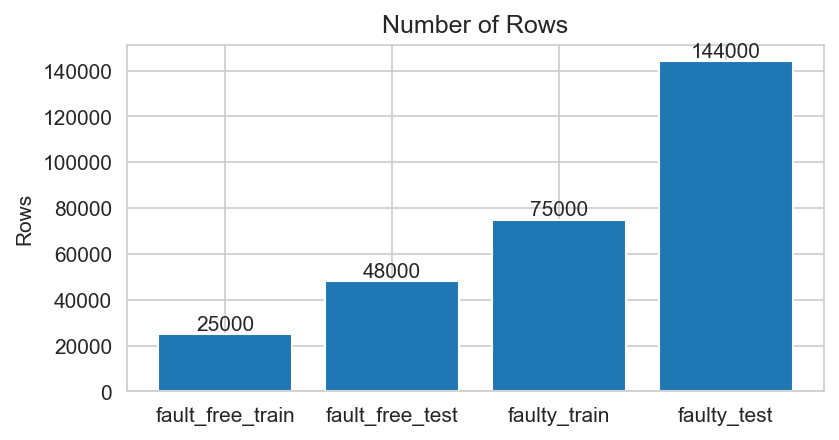

In [12]:
dfs = [df_fault_free_train, df_fault_free_test, df_faulty_train, df_faulty_test]
names = ['fault_free_train', 'fault_free_test', 'faulty_train', 'faulty_test']

plot_sizes(dfs, names)

The testing sets contain almost twice as many samples as the training sets, which is good for robust evaluation.

## Data Preparation for Analysis
Combine training datasets and prepare features for modeling.

In [13]:
df_train_full = pd.concat(objs=[df_fault_free_train, df_faulty_train], axis=0, ignore_index=True, copy=True)
df_test = pd.concat(objs=[df_fault_free_test, df_faulty_test], axis=0, ignore_index=True, copy=True)

Ensure fault numbers are properly formatted as categorical integers.

In [14]:
df_train_full['faultNumber'] = df_train_full['faultNumber'].astype(int)
df_test['faultNumber'] = df_test['faultNumber'].astype(int)

Remove individual dataframes to free up memory for analysis.

In [15]:
del df_fault_free_train, df_faulty_train, df_fault_free_test, df_faulty_test

In [16]:
df_train_full['faultNumber'].unique()

array([ 0,  1, 13, 16])

In [17]:
df_test['faultNumber'].unique()

array([ 0,  1, 13, 16])

### Create Binary Target Variable
Add a binary indicator for anomaly detection (normal vs. any fault type).

In [18]:
df_train_full['faulty'] = df_train_full['faultNumber'] > 0
df_test['faulty'] = df_test['faultNumber'] > 0

TARGET_COLUMN = 'faulty'

### Select Feature Columns
Identify process measurement and control variables for modeling.

In [19]:
ALL_FEATURE_COLUMNS = [col for col in df_train_full.columns if col.startswith('xmeas') or col.startswith('xmv')]

## Variability Analysis by Fault Type

The coefficient of variation measures the degree of variability relative to the mean for each variable. By analyzing this metric across different fault types, we can identify which features show the most distinctive patterns for each fault.

Higher coefficient values (shown in yellow/green) indicate features that show significant changes during specific fault conditions, making them potentially valuable for fault detection and classification.

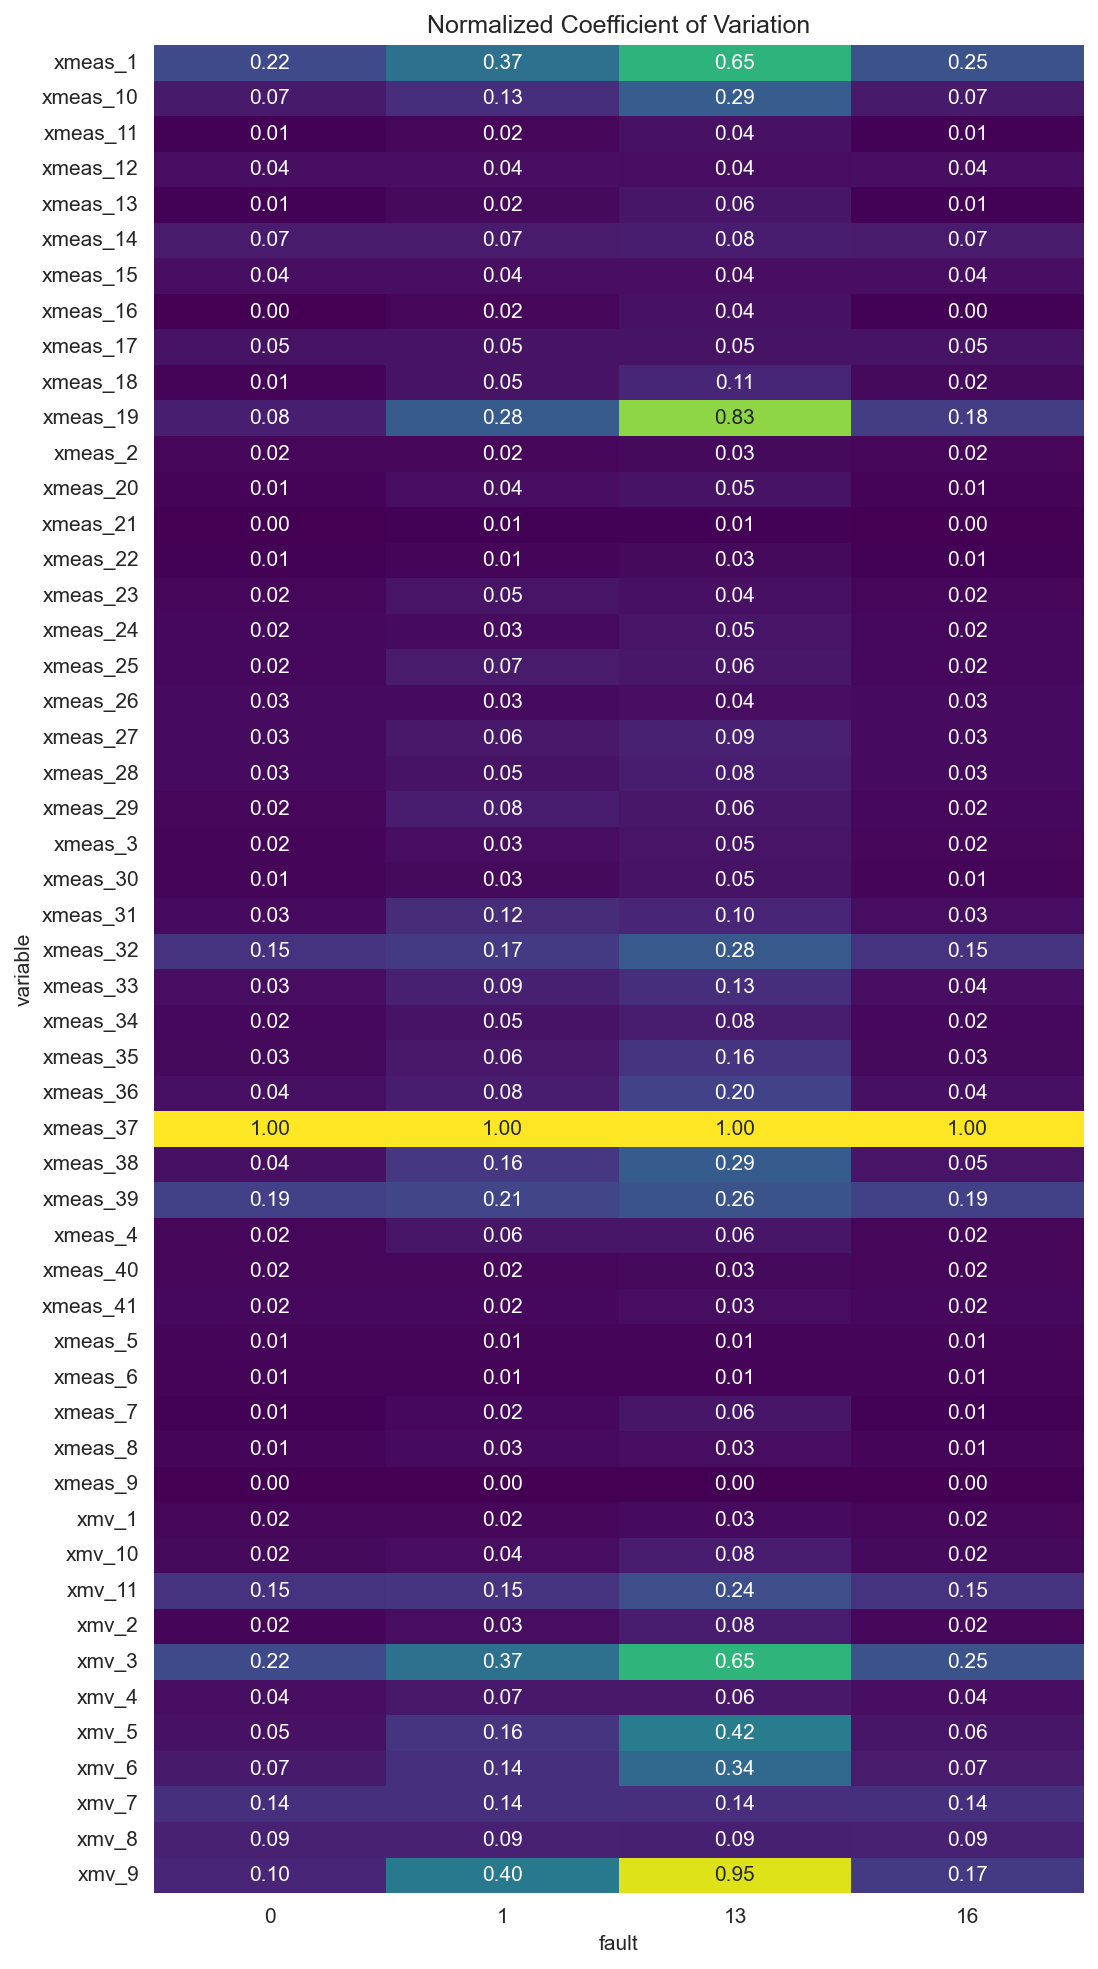

In [20]:
plot_variability_analysis(data=df_train_full, hue='faultNumber', columns=ALL_FEATURE_COLUMNS, normalize=True)

**The most interesting features for each fault:** <br>
Fault 1: `xmeas_1`, `xmeas_19`, `xmeas_32`, `xmeas_37`, `xmeas_39`, `xmv_11`, `xmv_3`, `xmv_9` <br>
Fault 13: `xmeas_1`, `xmeas_10`, `xmeas_19`, `xmeas_32`, `xmeas_37`, `xmeas_38`, `xmeas_39`, `xmv_3`, `xmv_5`, `xmv_6`, `xmv_9`, `xmv_11` <br>
Fault 16: `xmeas_1`, `xmeas_32`, `xmeas_37`,  `xmeas_39`, `xmv_3`, `xmv_9`

## Feature Importance Analysis Using Mutual Information

Mutual information measures the statistical dependence between each feature and the target variable (faulty vs normal). Higher scores indicate features that are more informative for distinguishing between normal and faulty conditions.

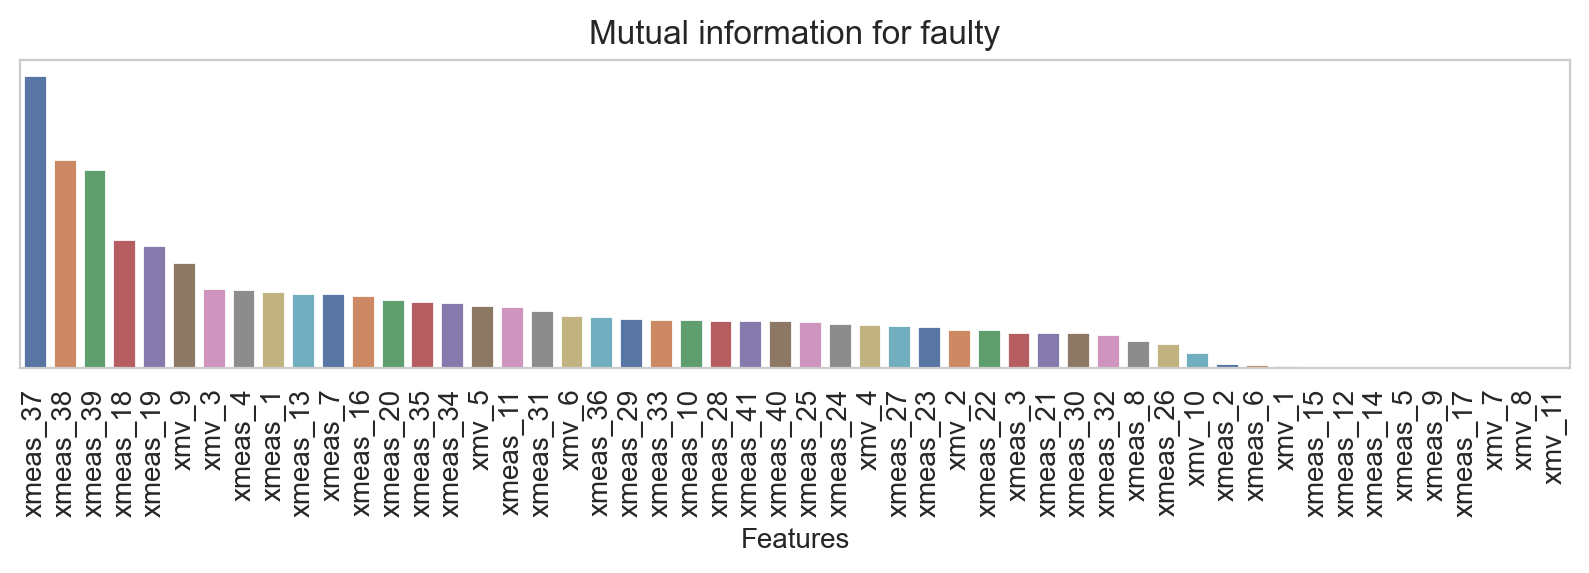

In [21]:
plot_mutual_info(data=df_train_full, feature_columns=ALL_FEATURE_COLUMNS, target_column=TARGET_COLUMN)

**Key Observations:**
- Top features (`xmeas_37`, `xmeas_38`) show strong relationships with fault detection
- Some features with high variability from the previous analysis show unexpectedly low mutual information scores (for instance, `xmv_11`)
- This suggests that high variability alone doesn't guarantee discriminative power for classification

## Time Series Analysis of Selected Features

Based on the variability and mutual information analyses, we select the 15 most informative features to examine their temporal patterns across different fault conditions.

### Feature Selection Criteria
Features were chosen based on:
- High coefficient of variation for specific fault types
- Strong mutual information with the target variable


In [22]:
SELECTED_FEATURE_COLUMNS = [
    'xmeas_1', 'xmeas_4', 'xmeas_10', 'xmeas_13', 'xmeas_16', 'xmeas_18', 'xmeas_19', 'xmeas_32', 'xmeas_37', 'xmeas_38', 'xmeas_39',
    'xmv_3', 'xmv_5', 'xmv_6', 'xmv_9',
]

len(SELECTED_FEATURE_COLUMNS)

15

### Visualization Approach
To maintain chart clarity, we display only the first 3 simulations per fault type, which is sufficient to observe characteristic patterns.

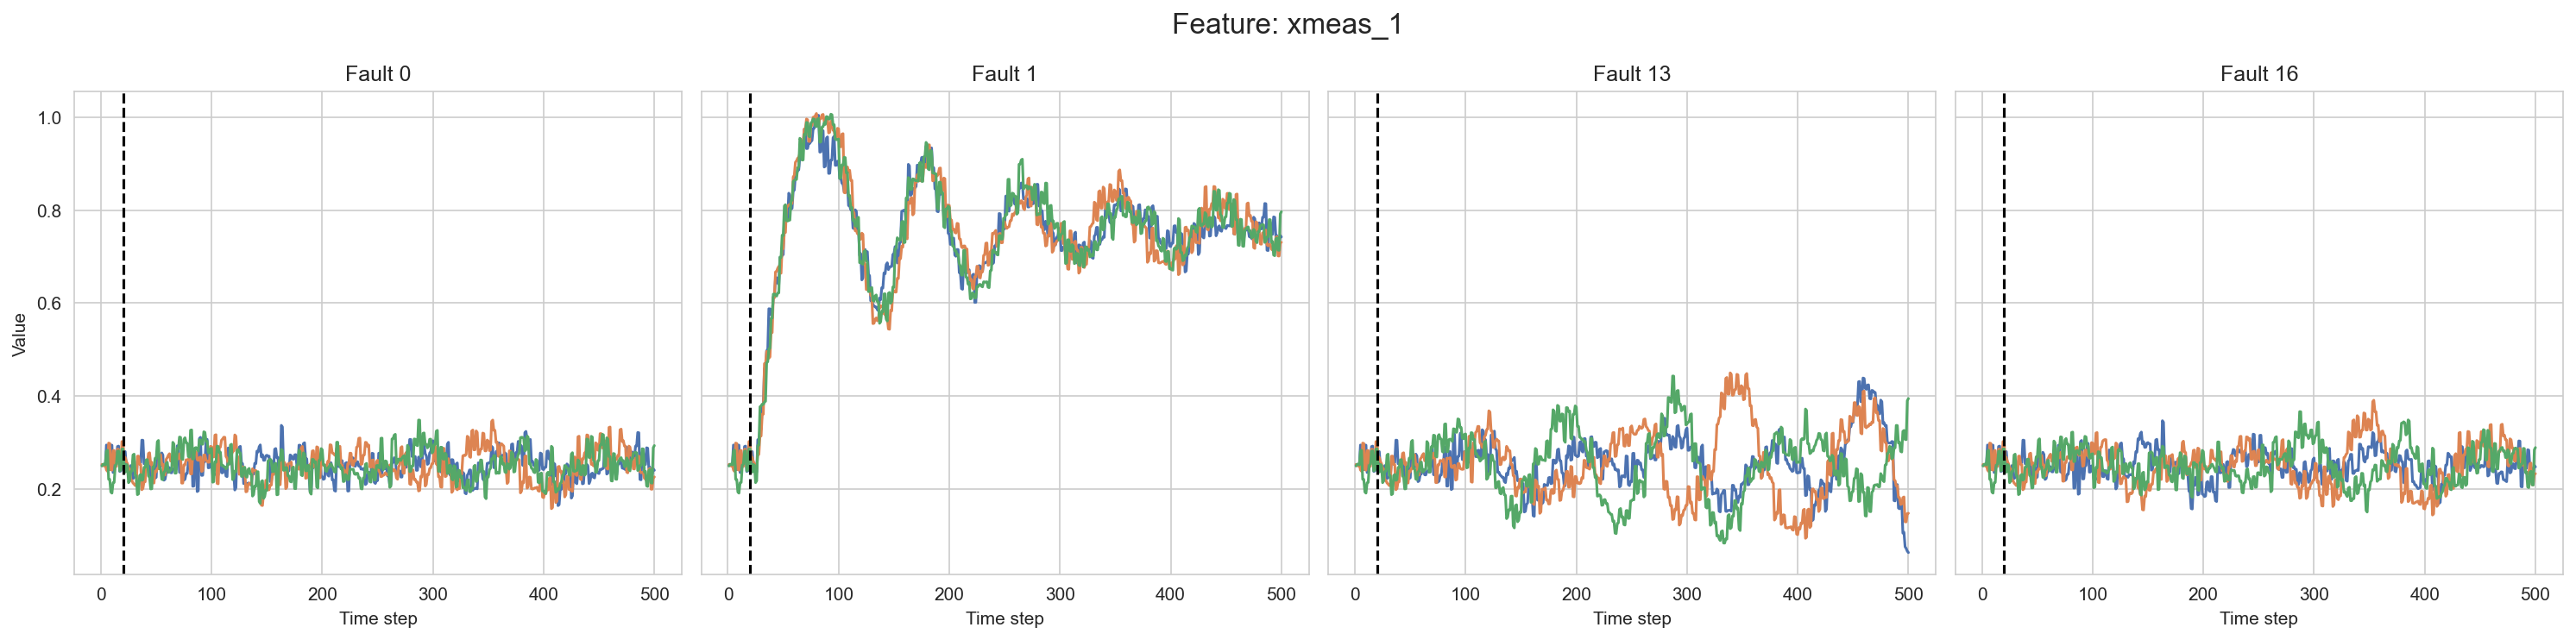

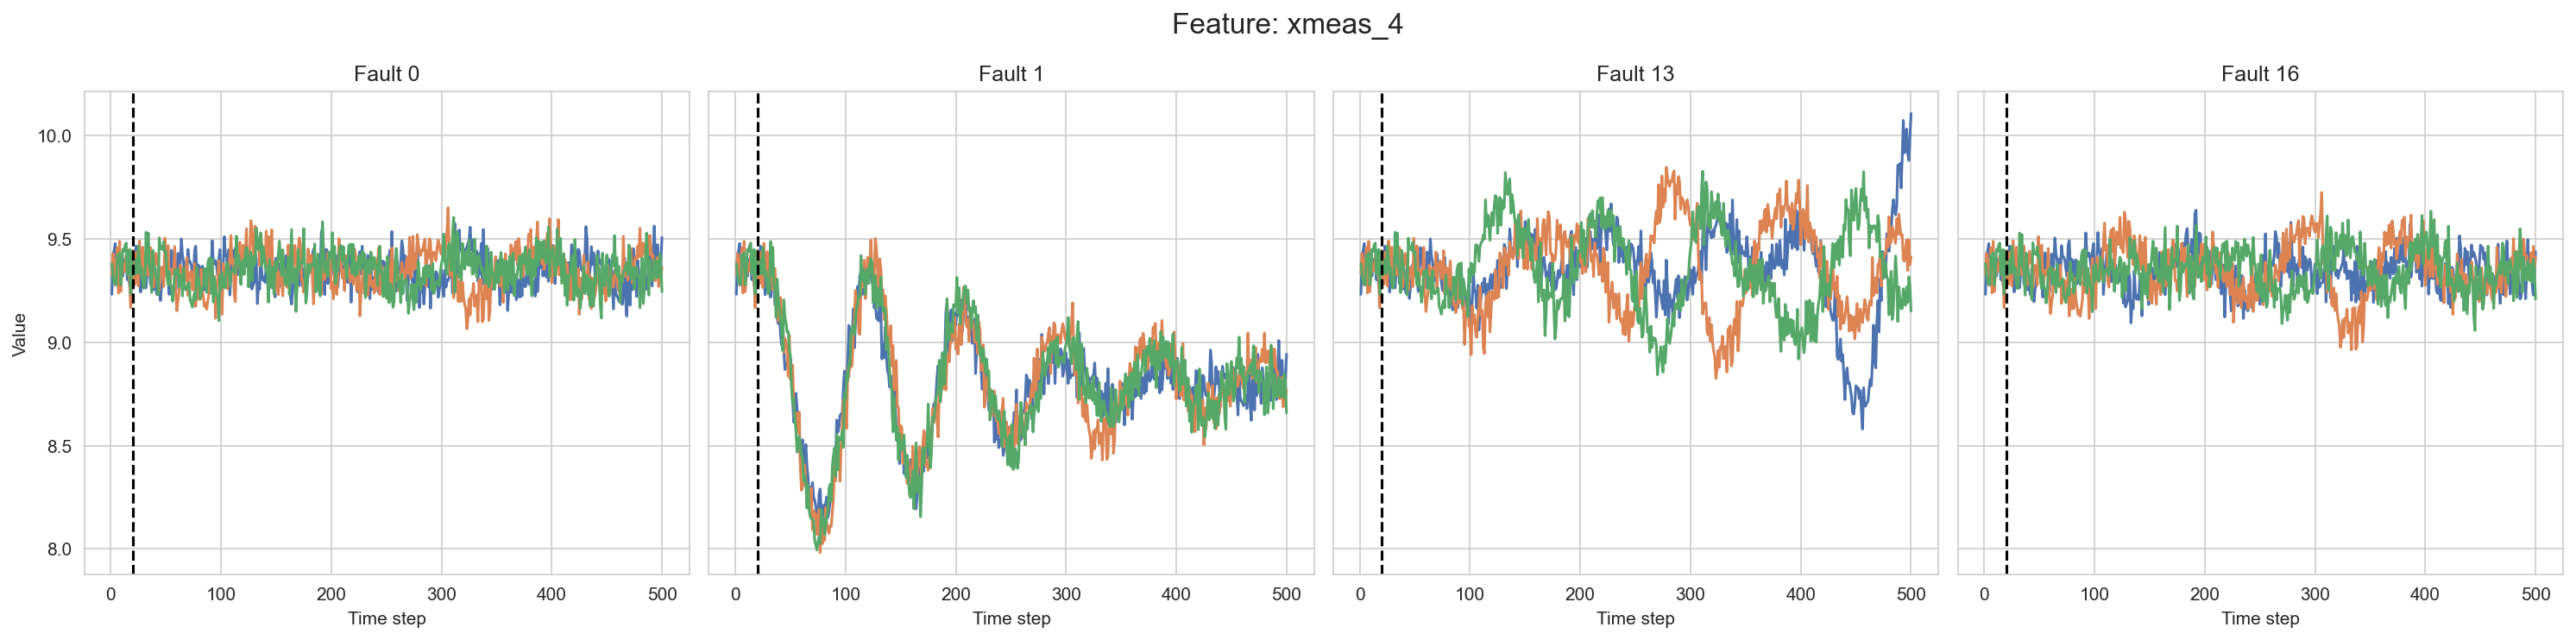

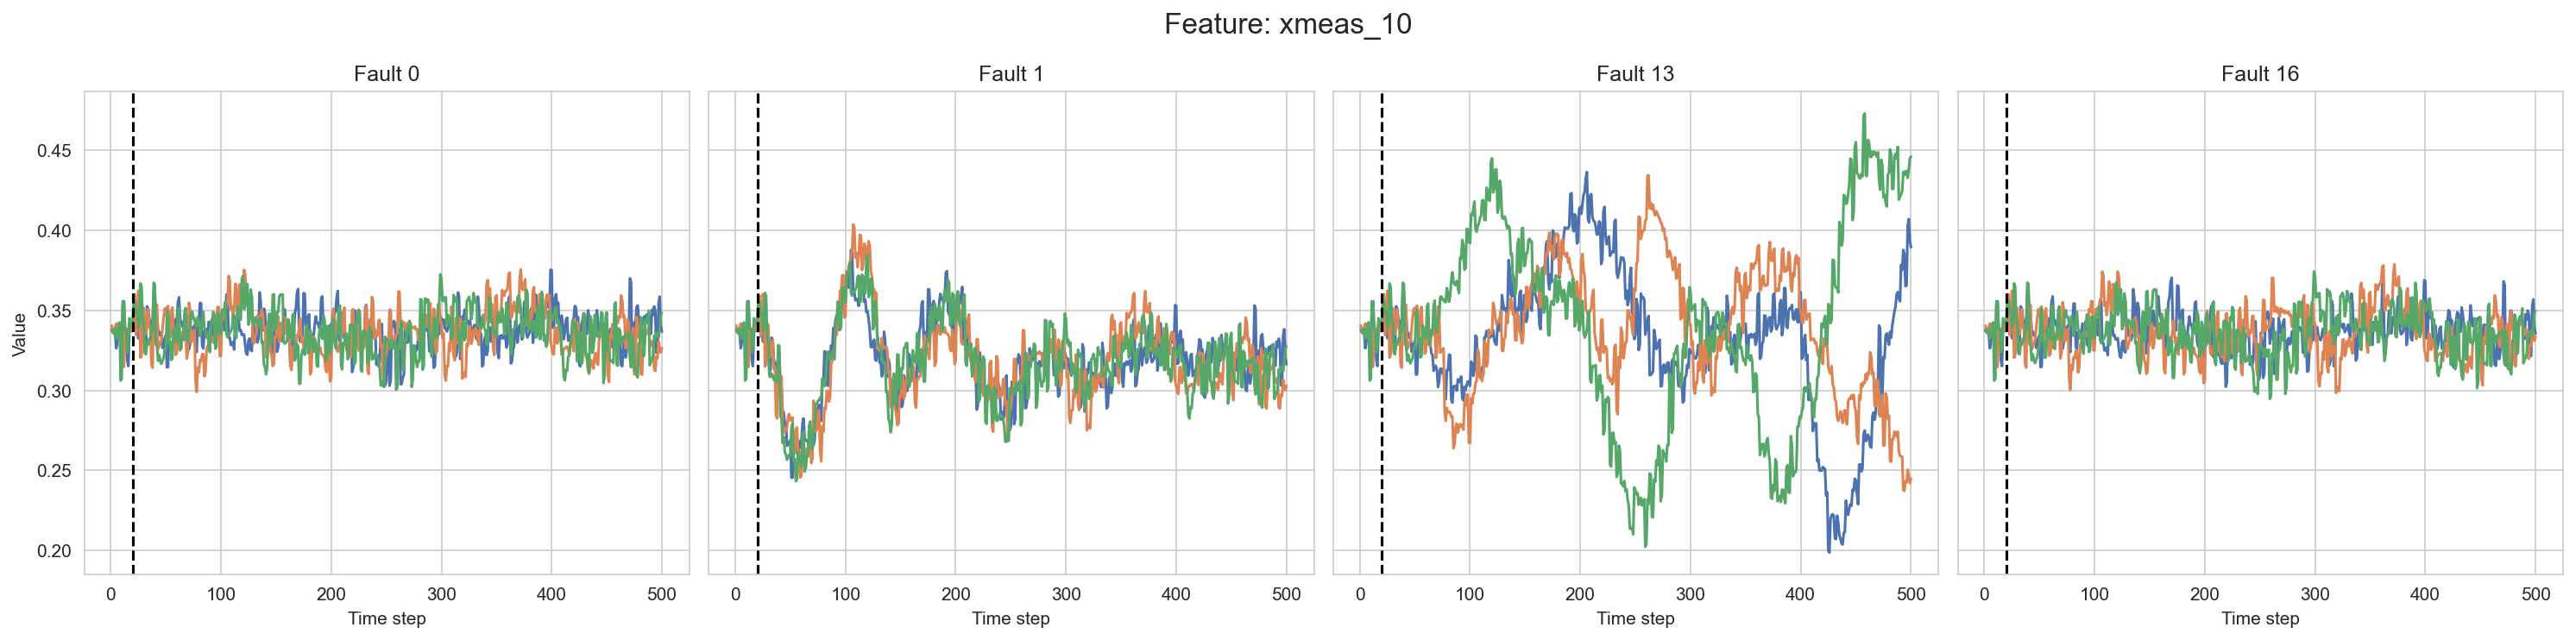

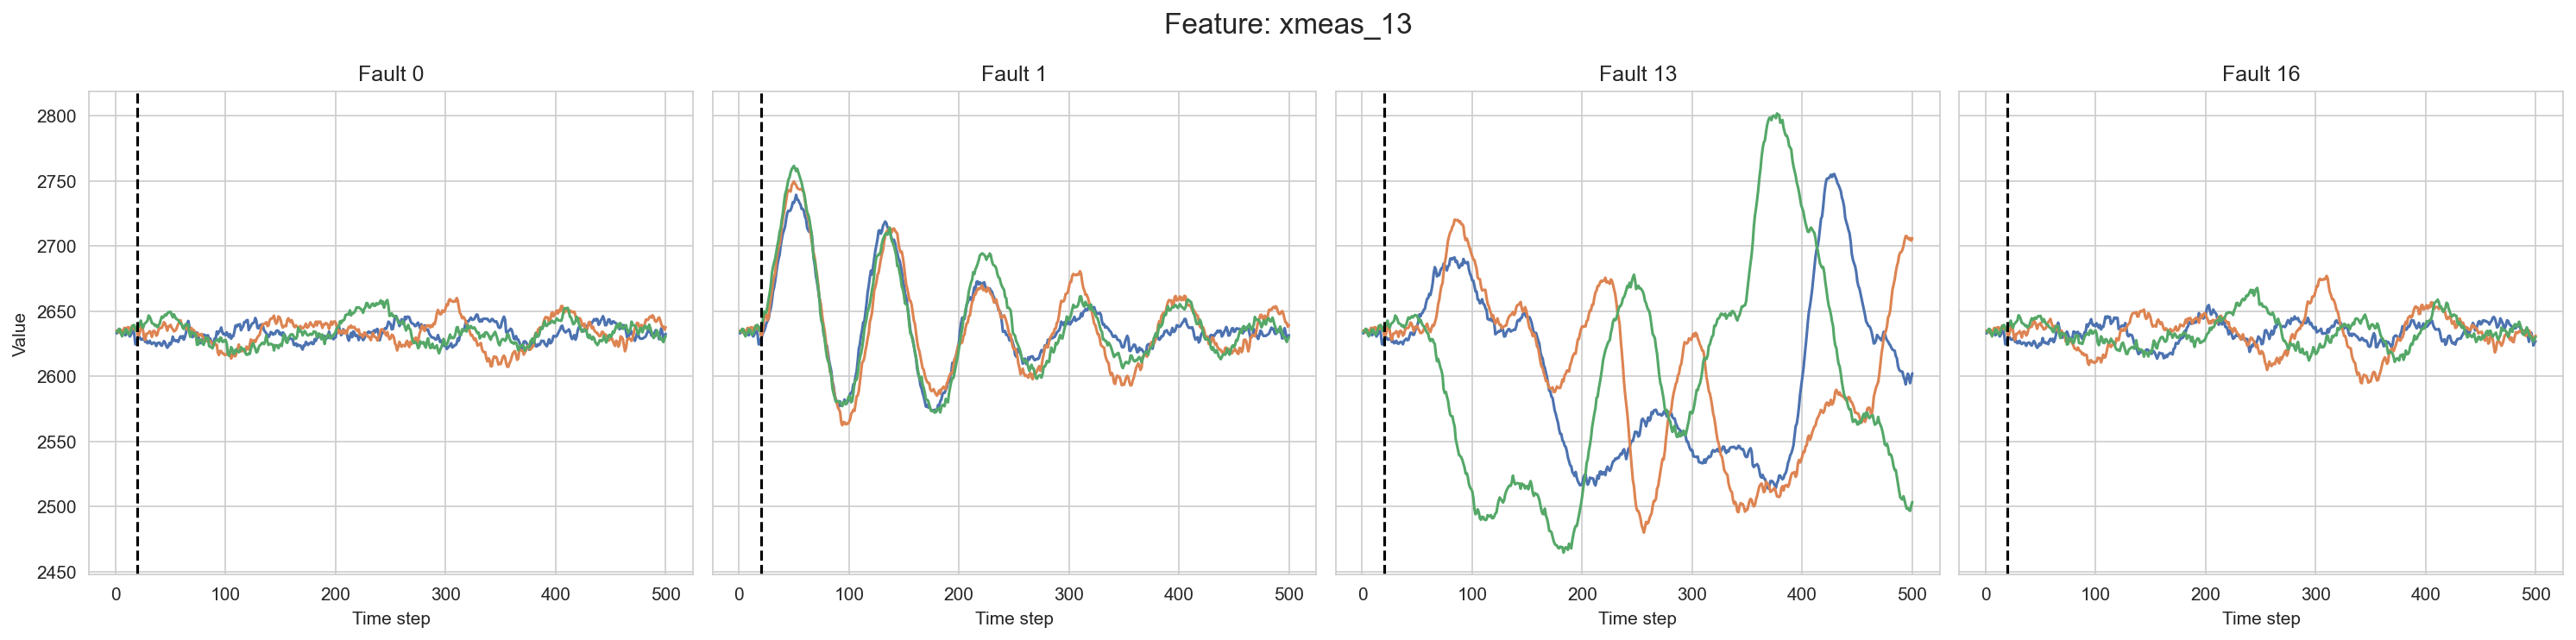

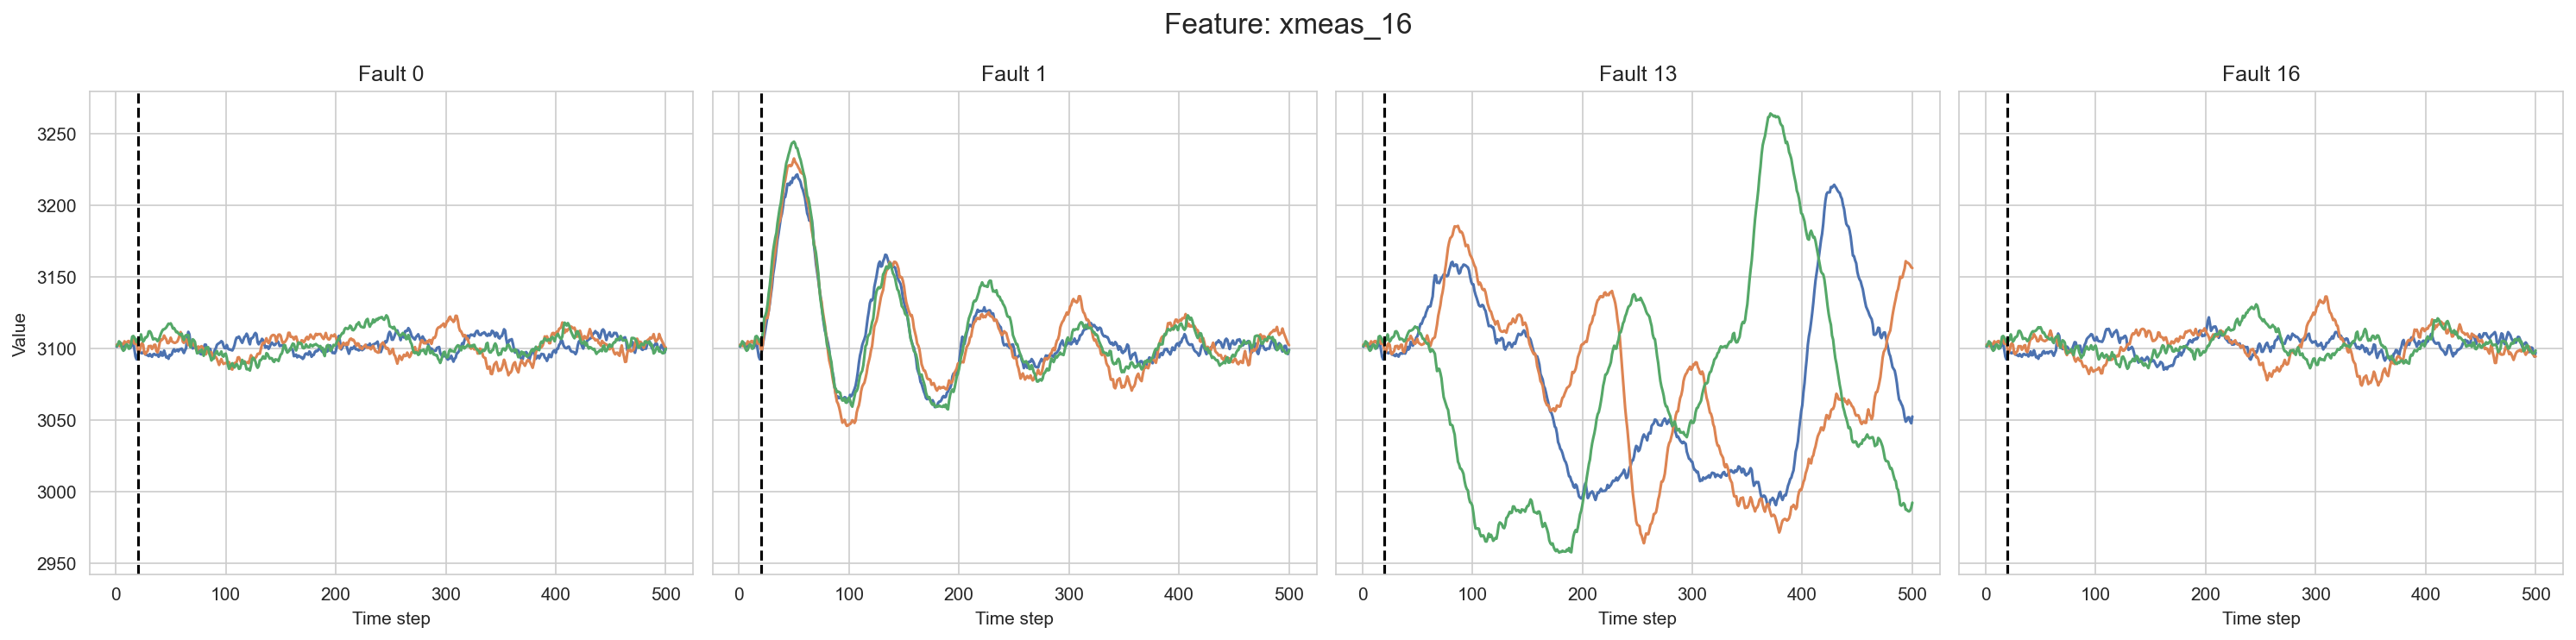

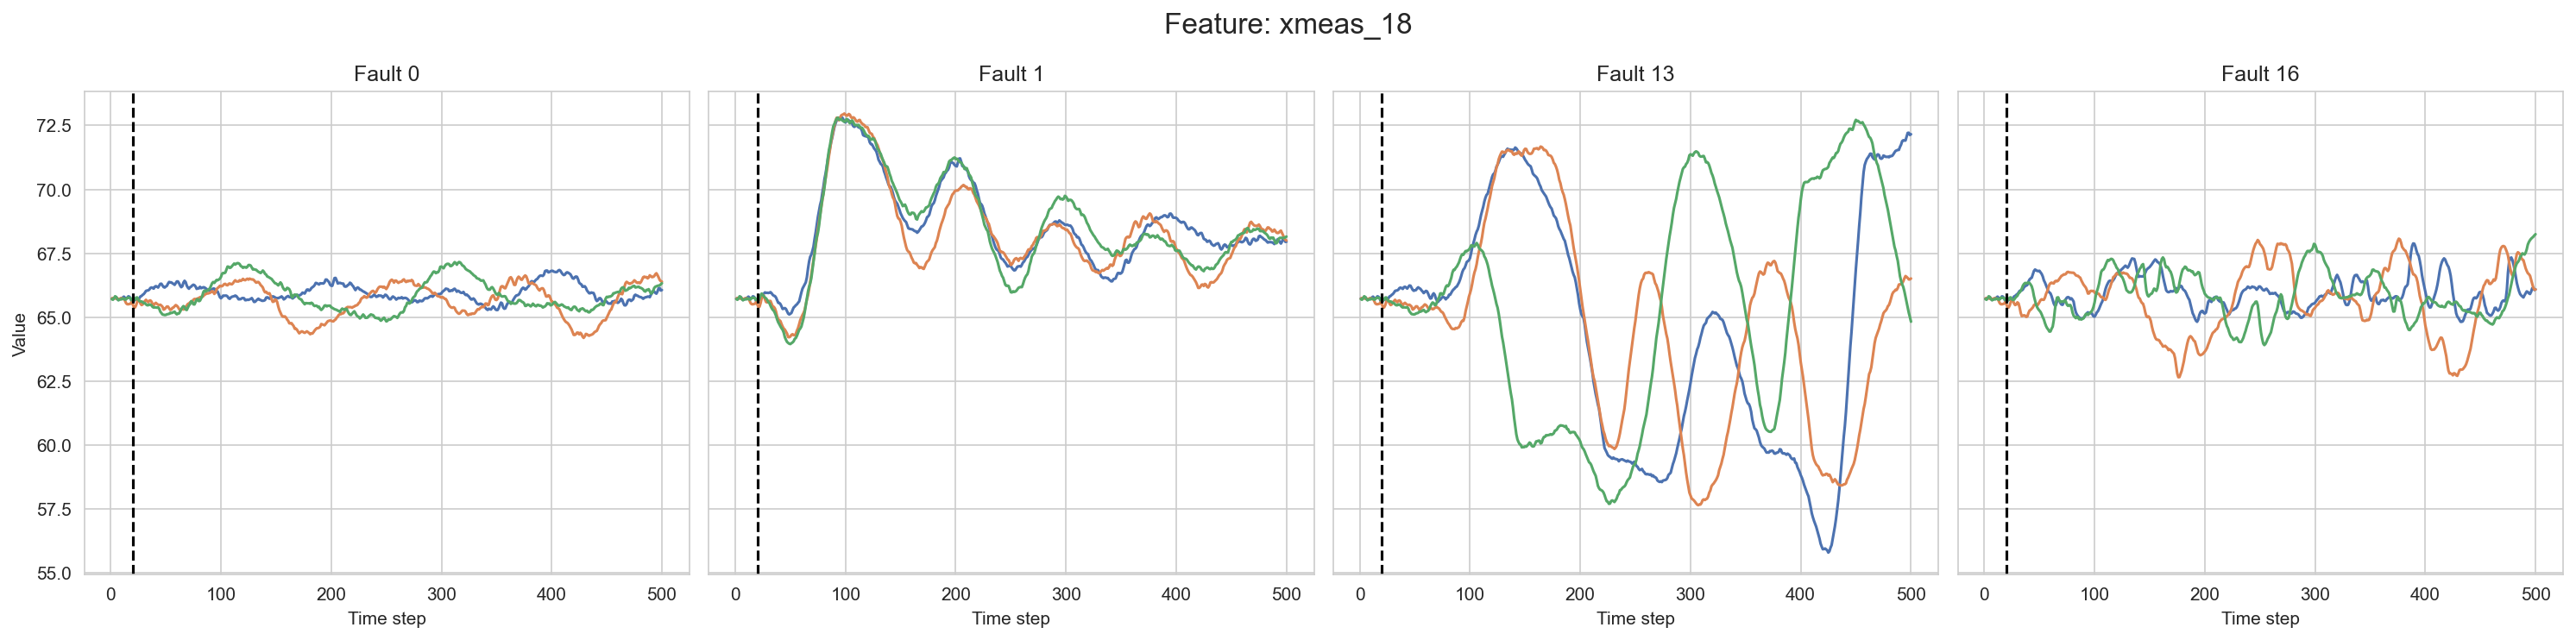

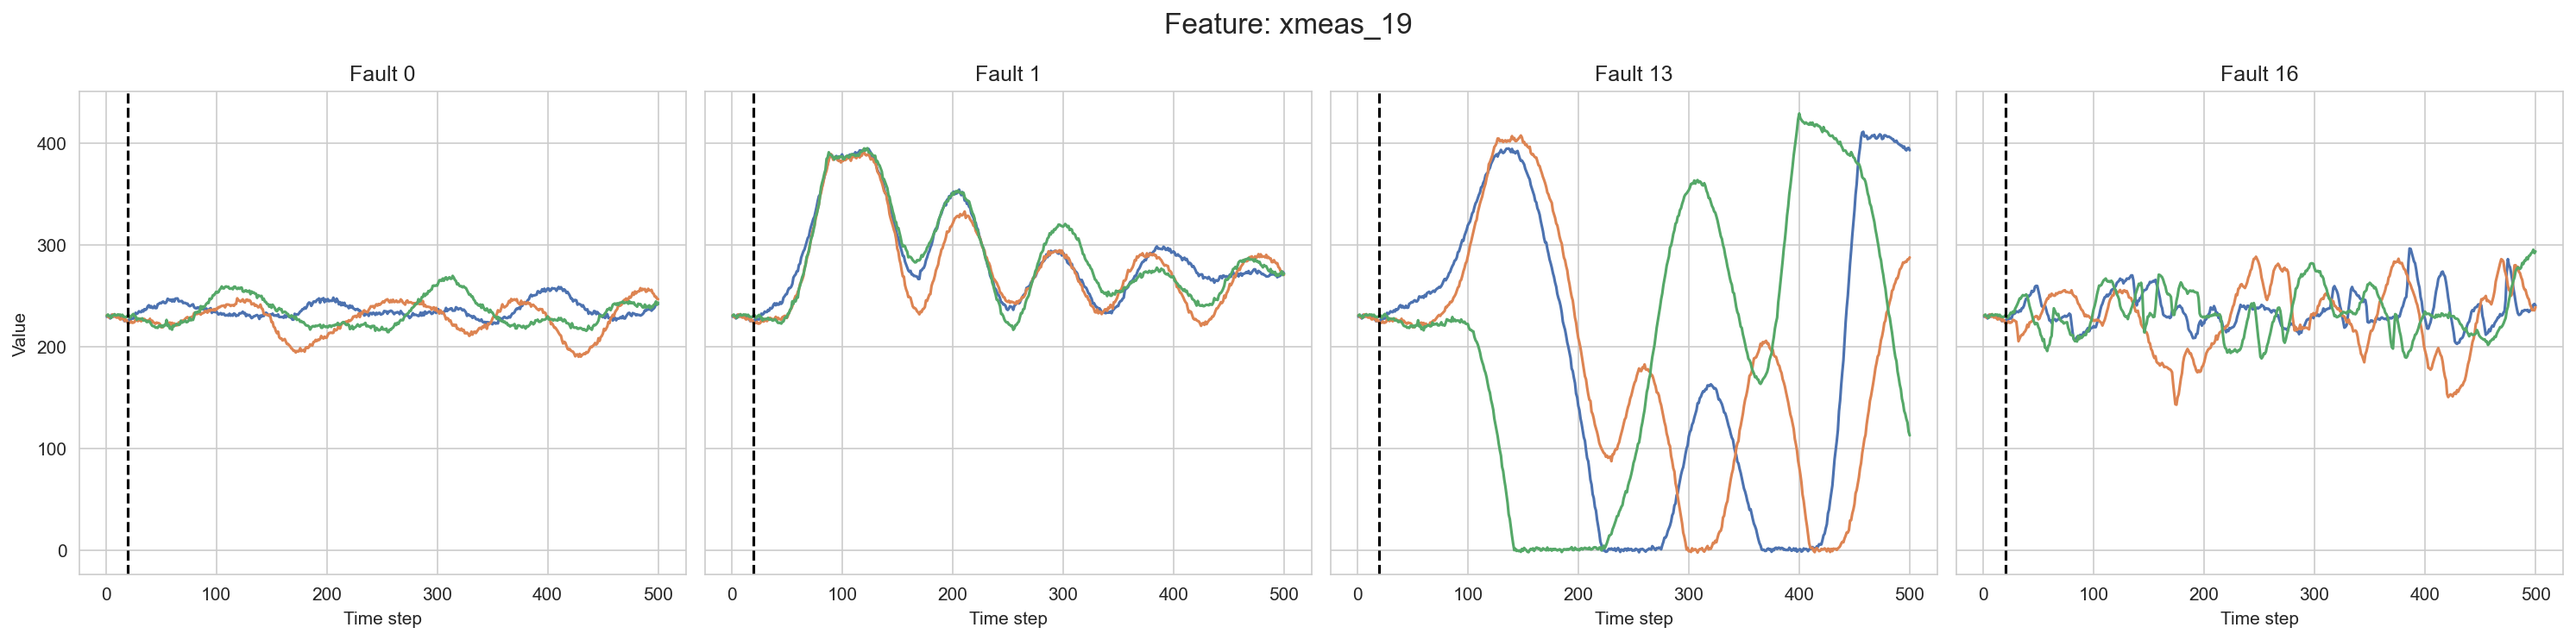

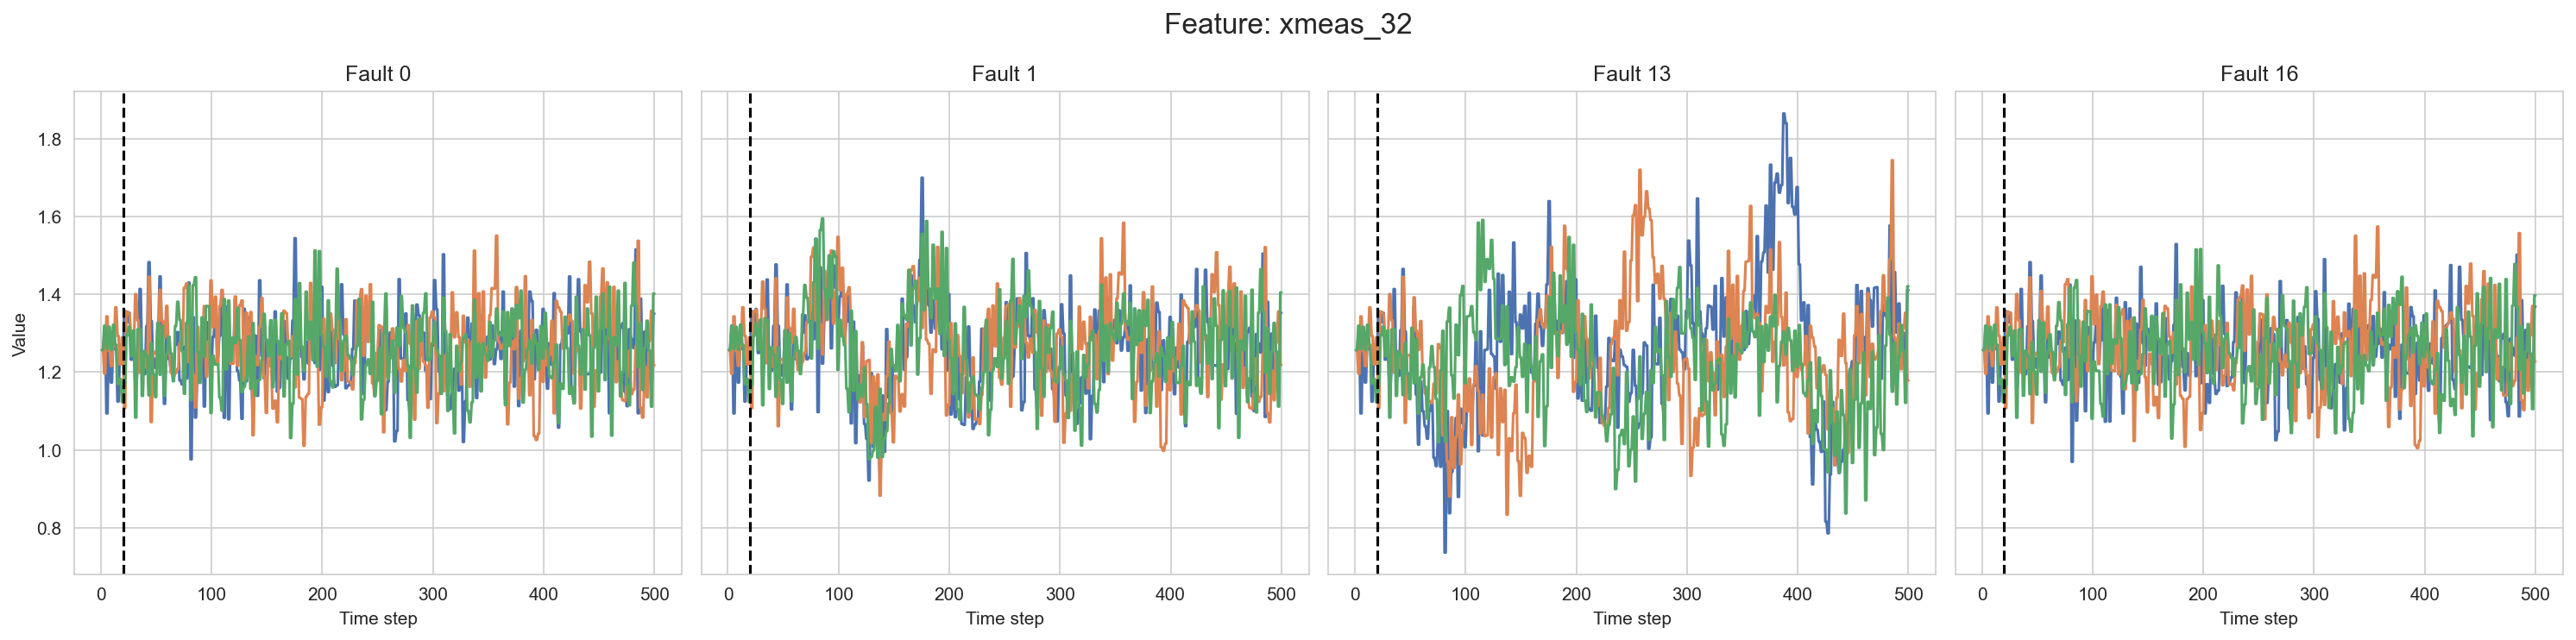

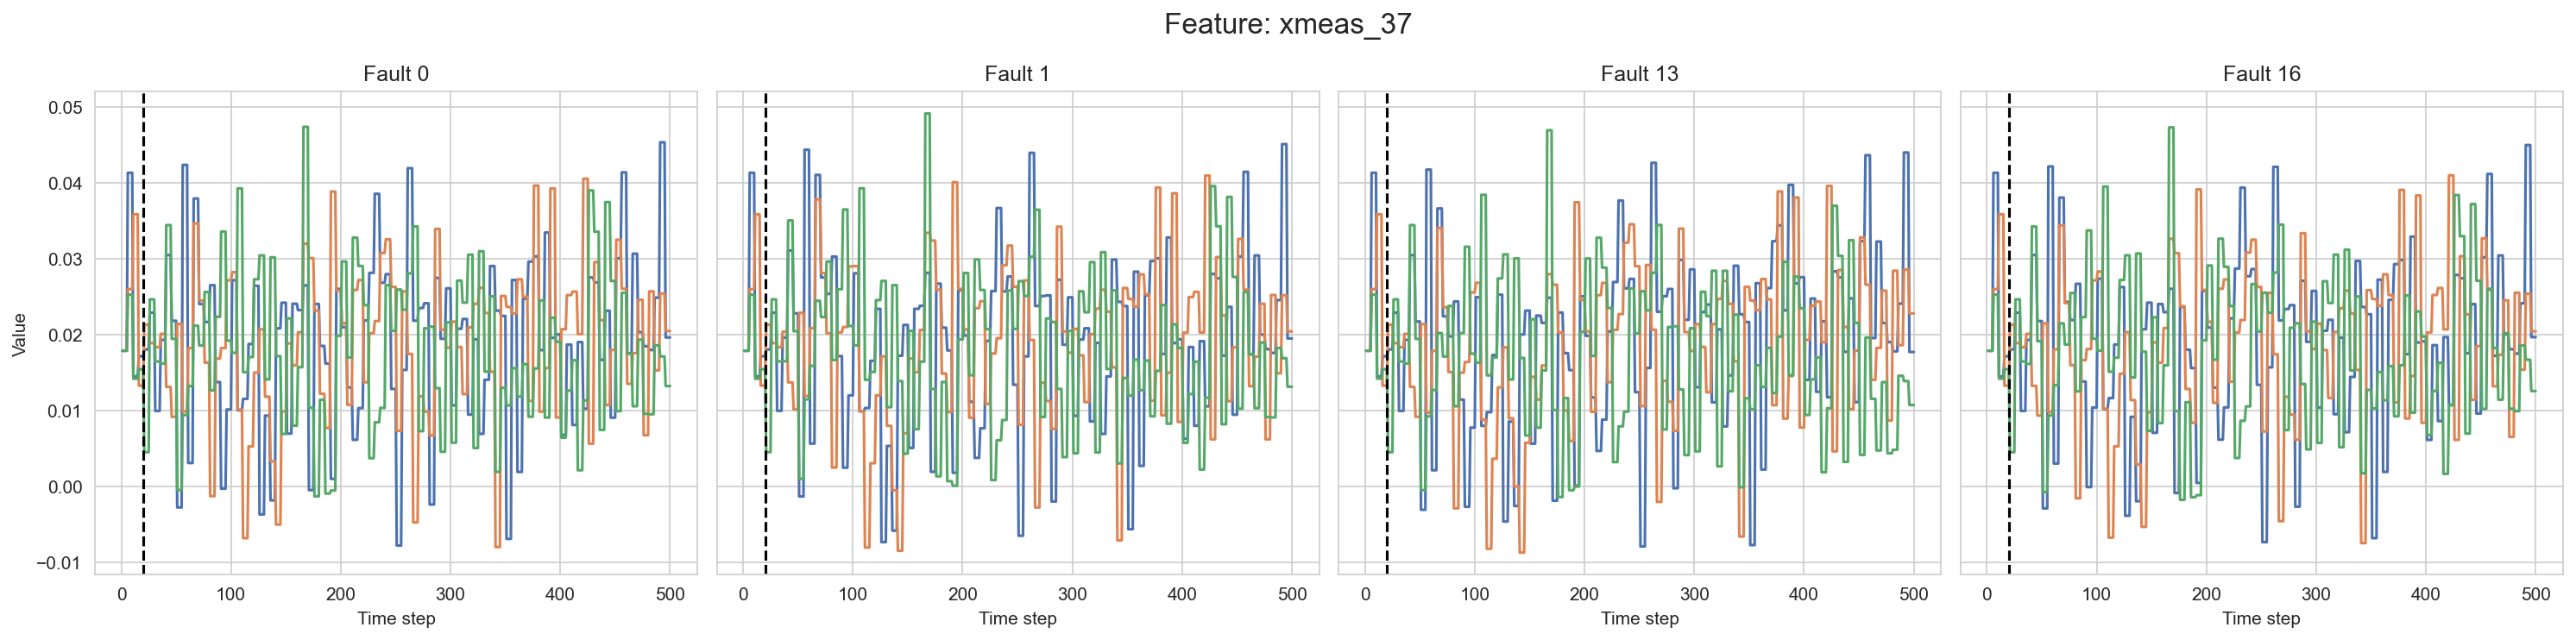

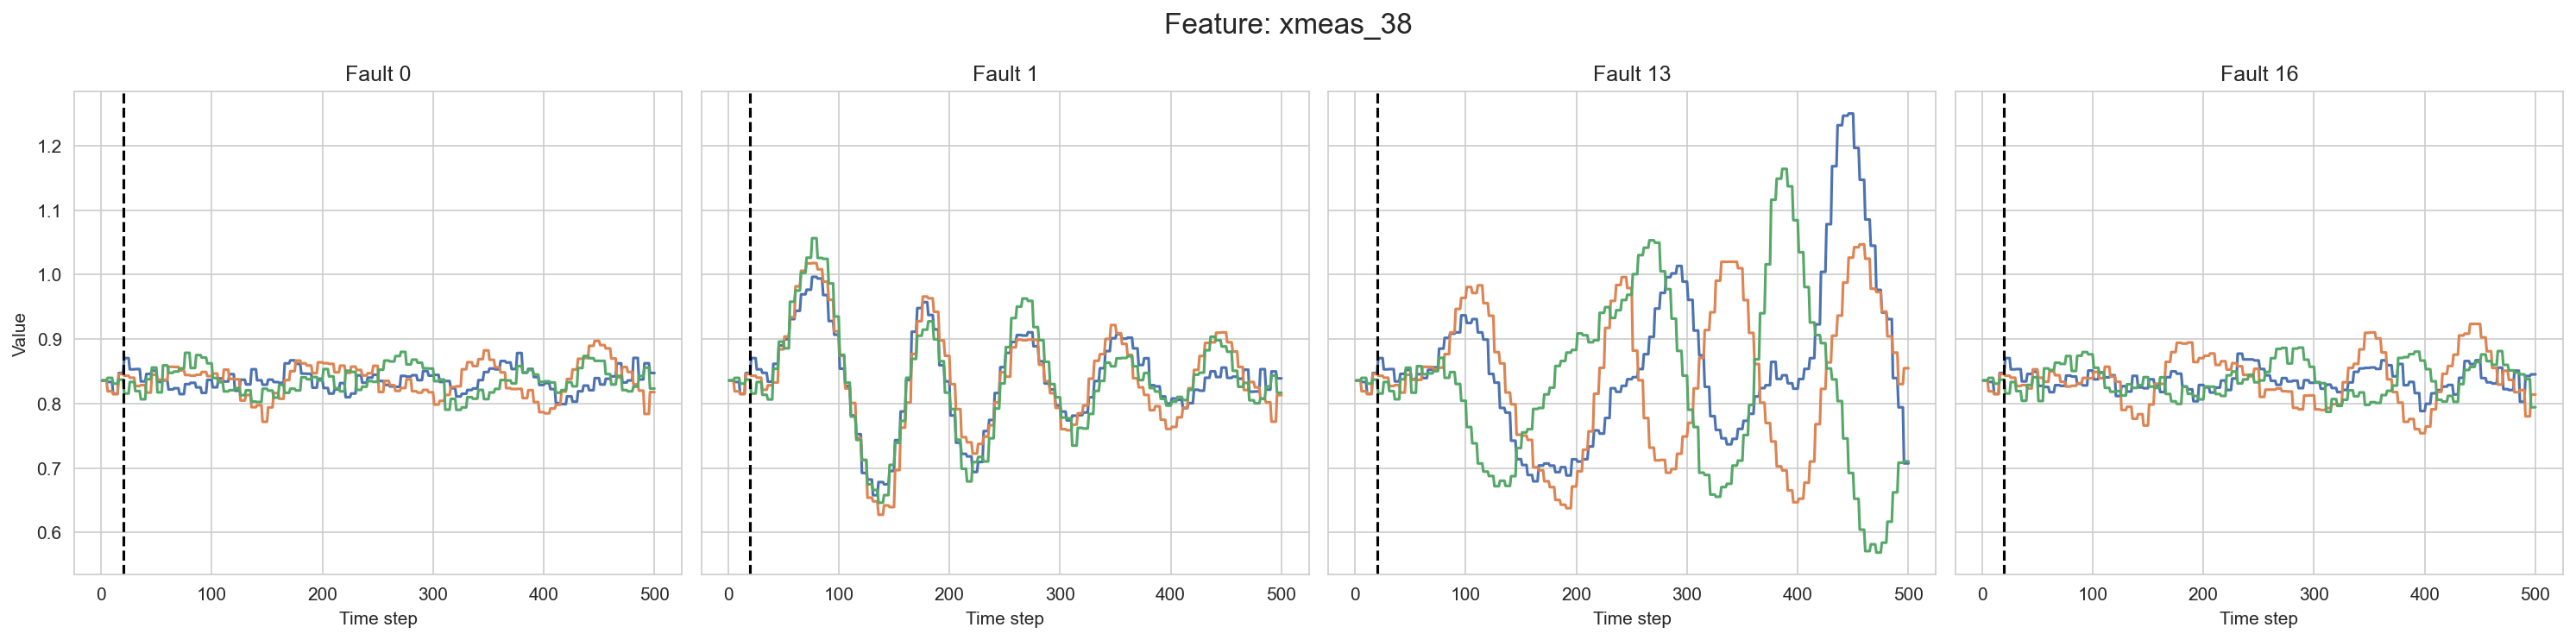

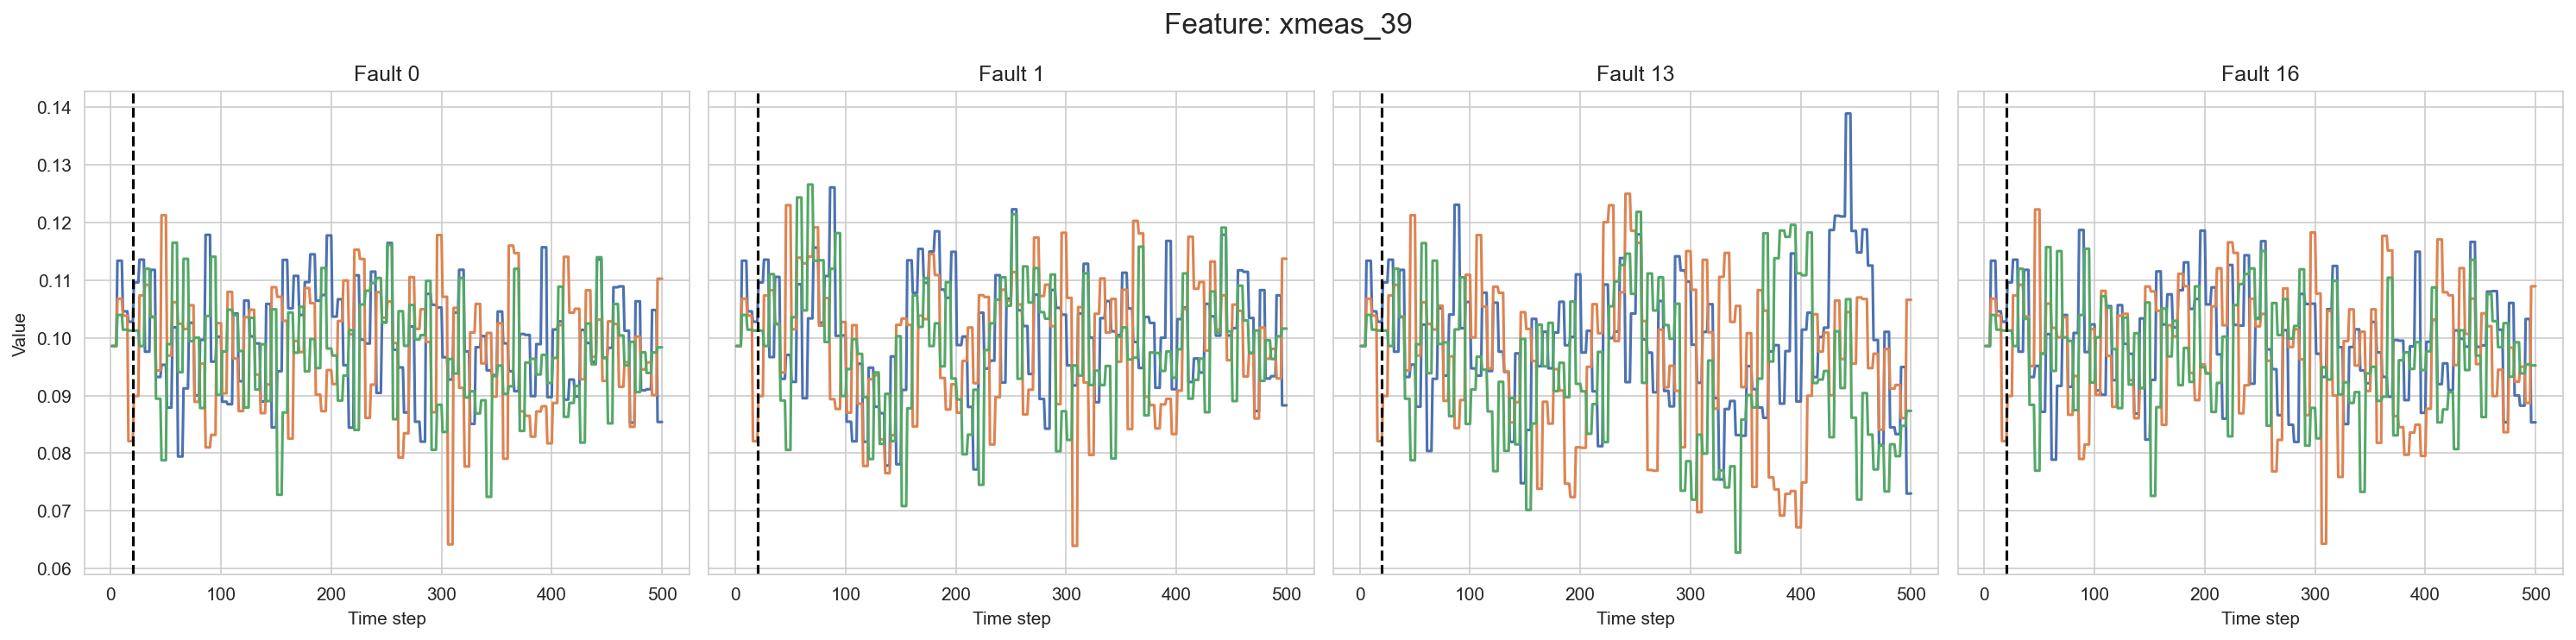

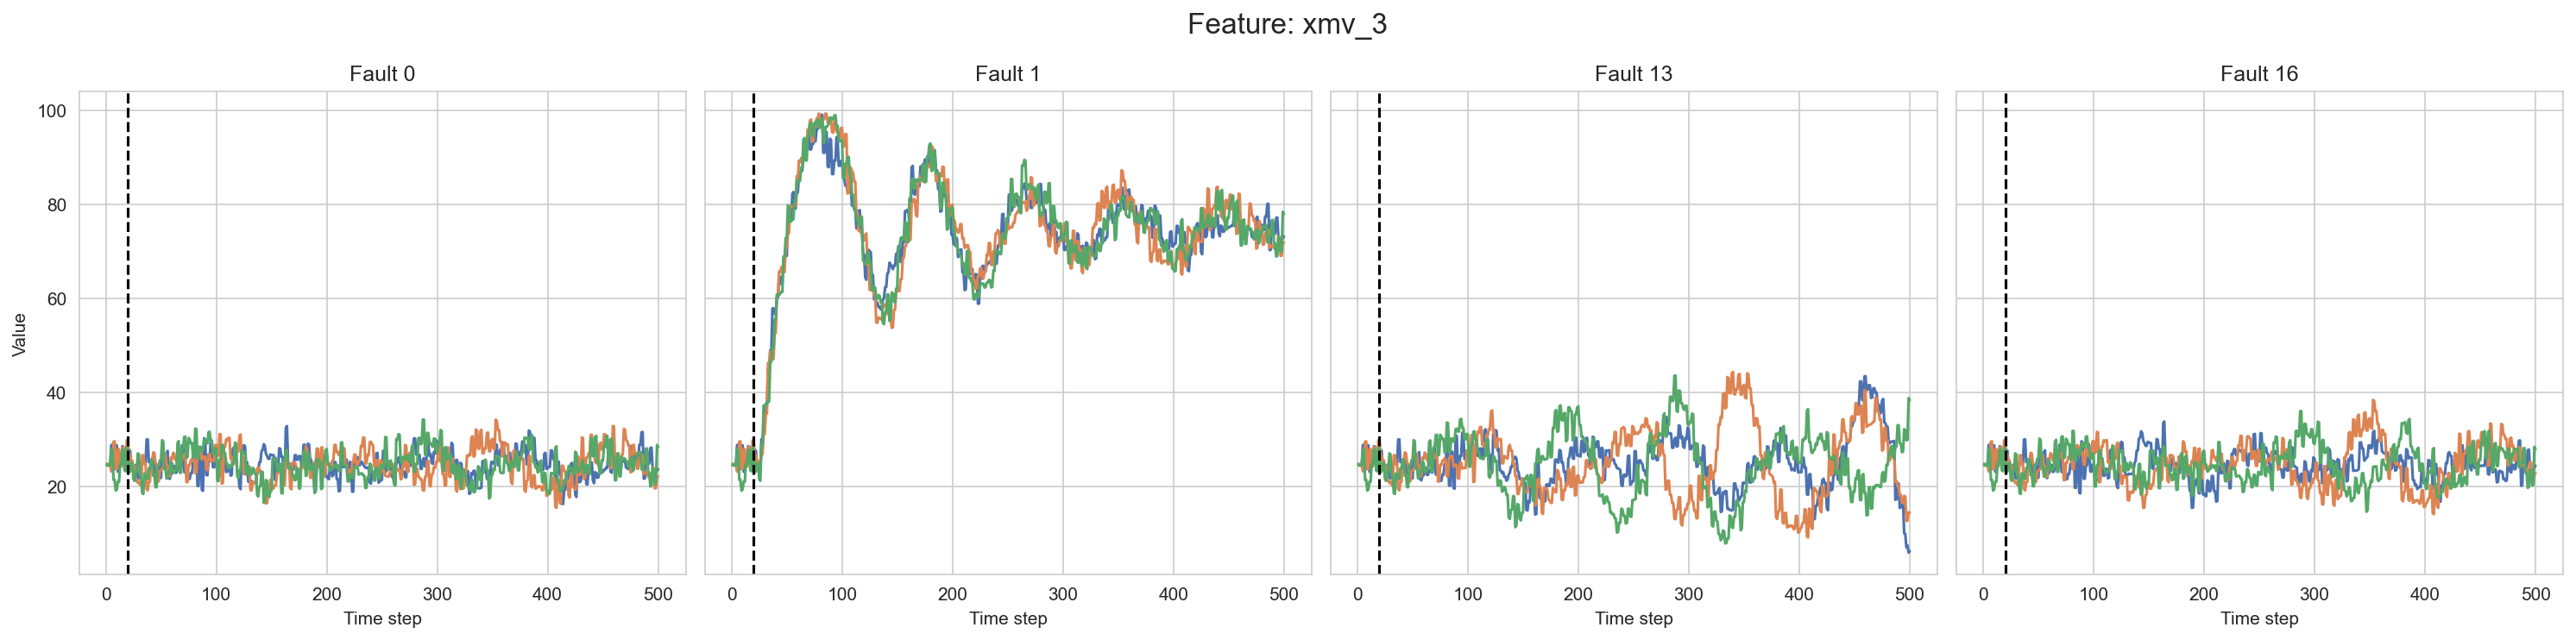

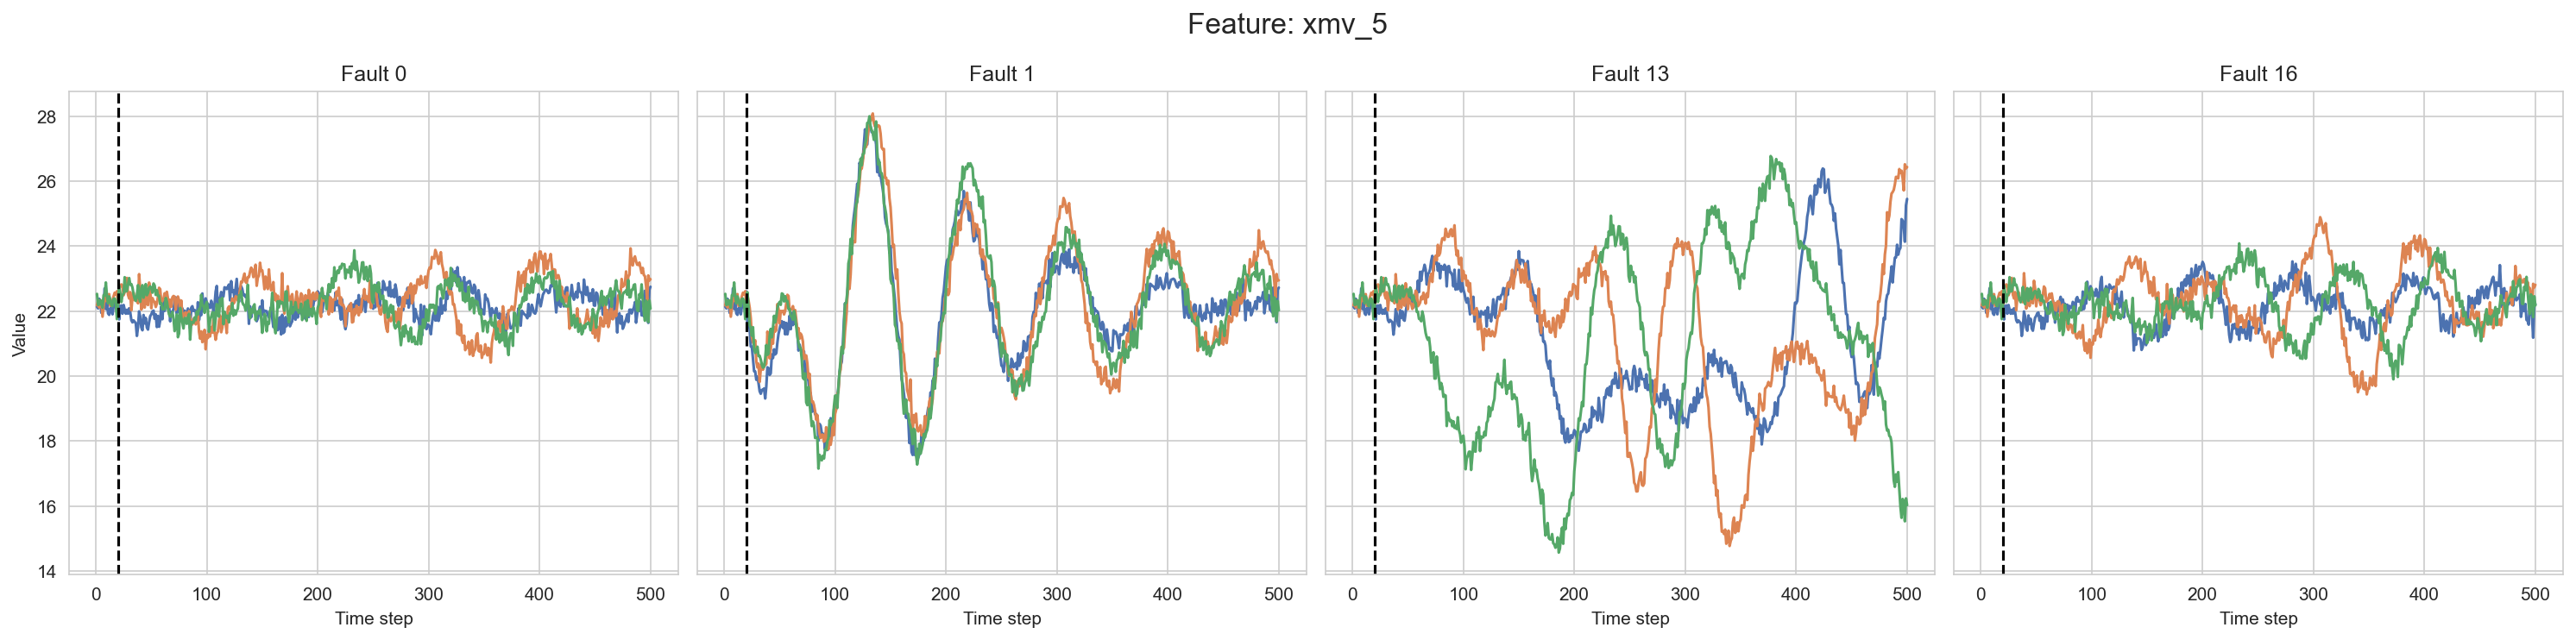

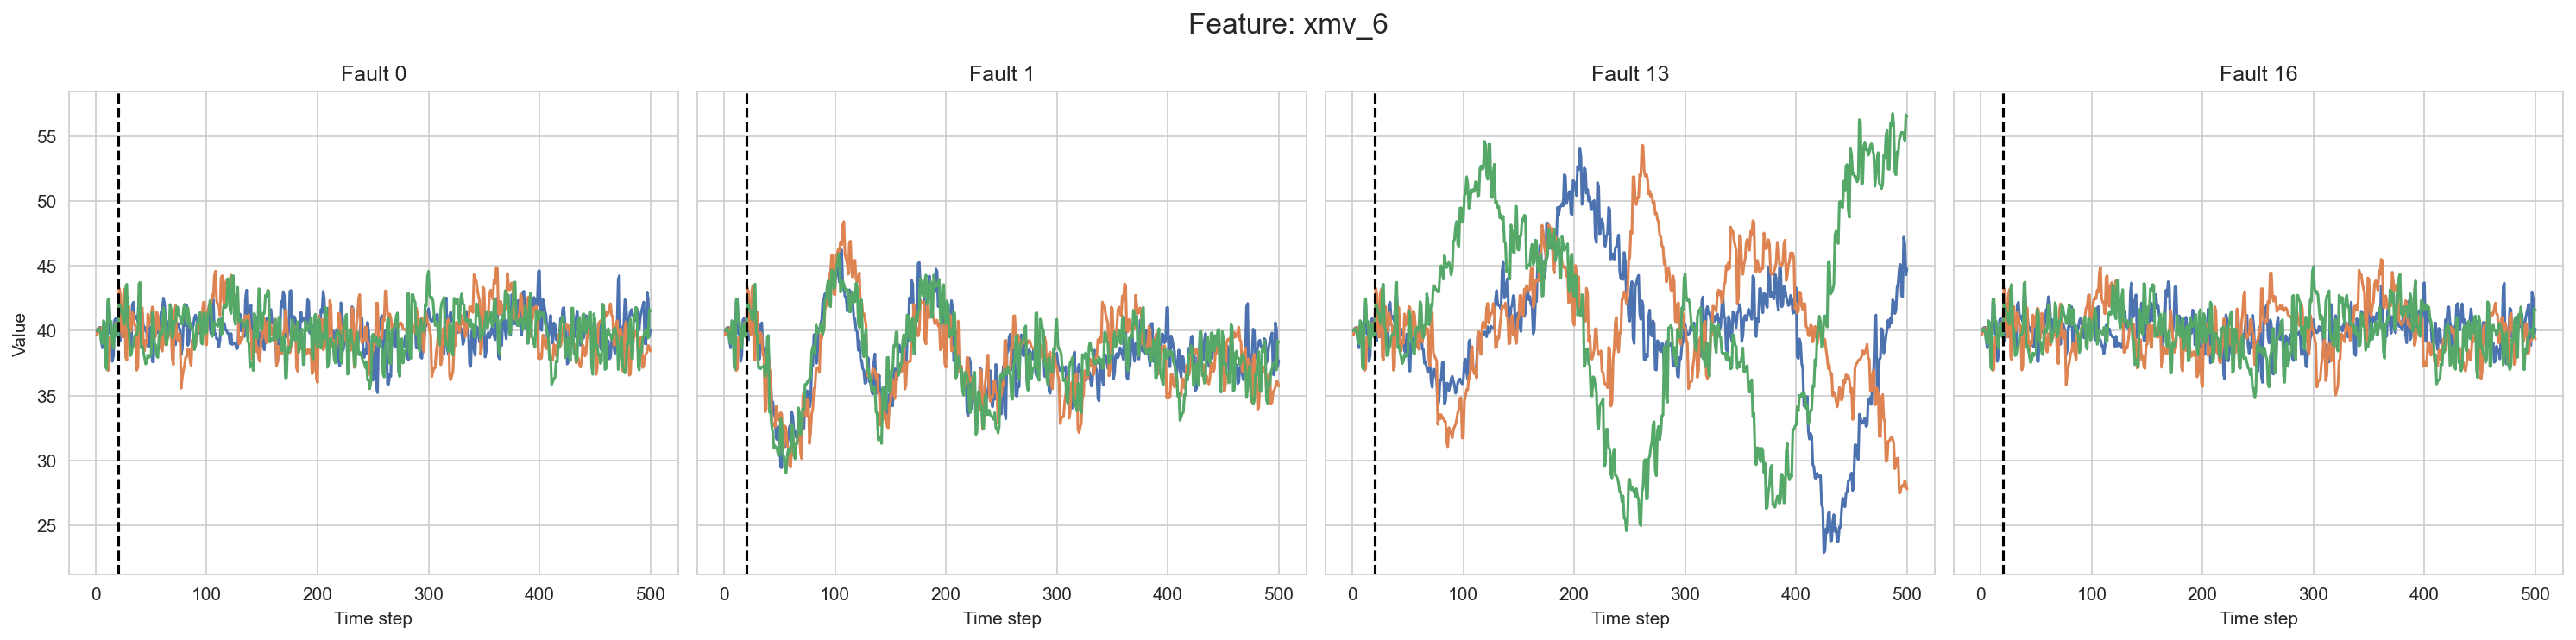

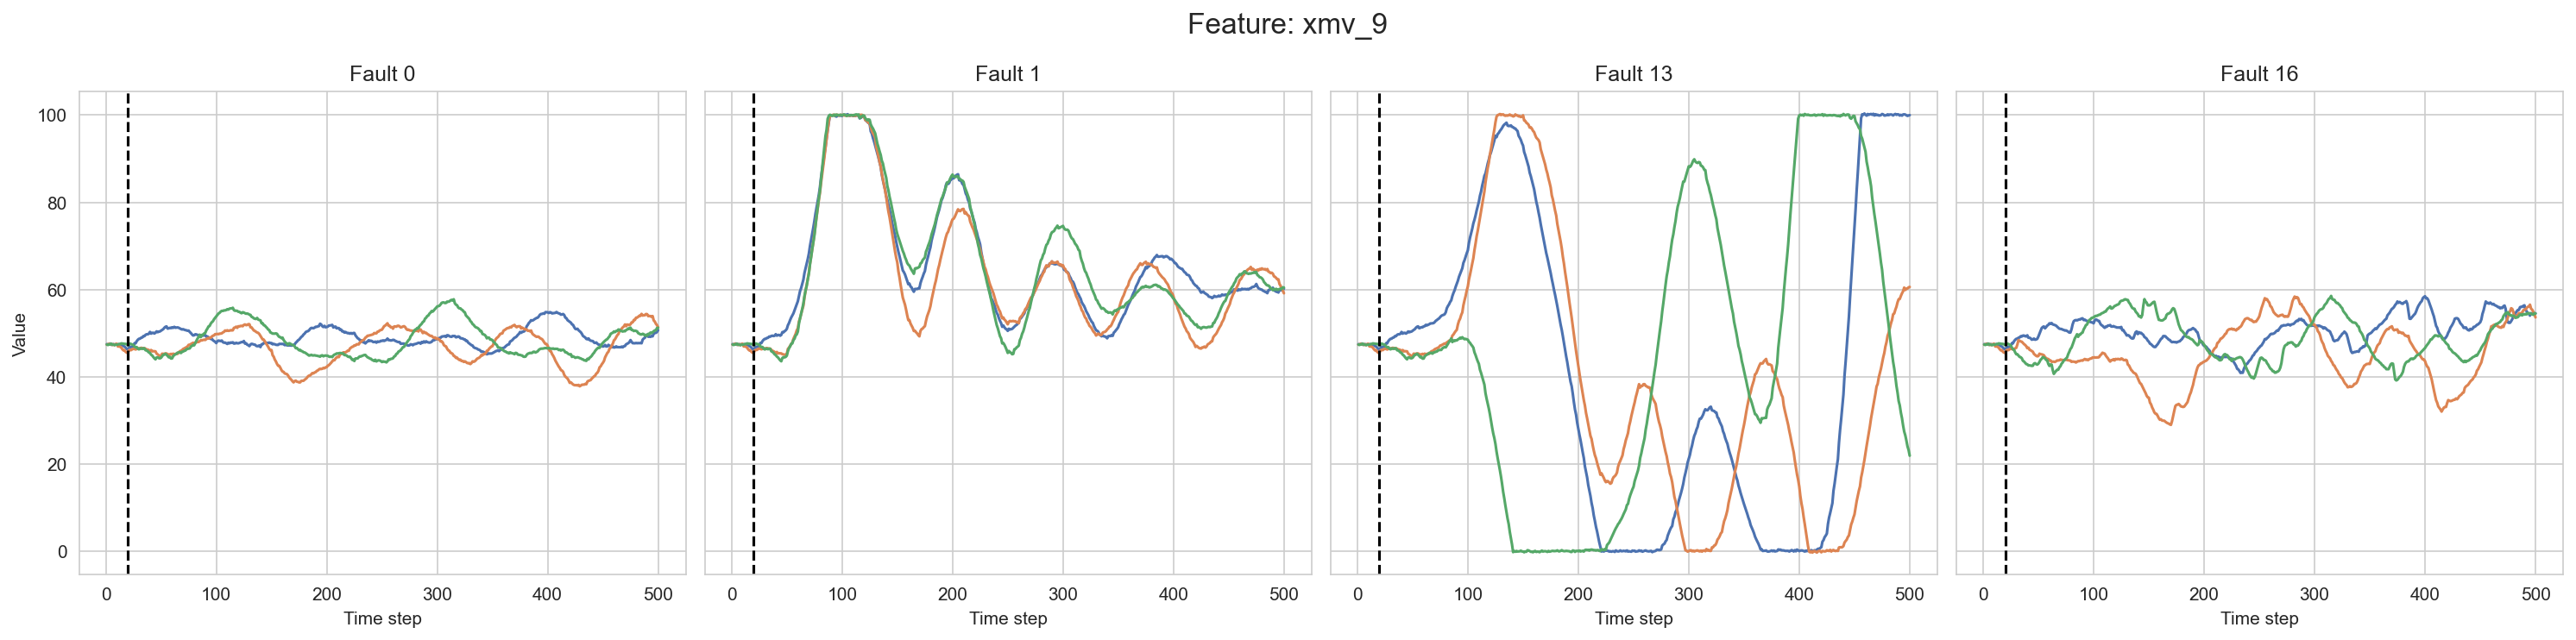

In [23]:
plot_fault_comparison_timeseries(data=df_train_full, columns=SELECTED_FEATURE_COLUMNS, faults=SELECTED_FAULTS, xline=20)

**Observations:**
- Fault types 1 and 13 produce distinct temporal anomalies, while fault type 16 deviates more moderate. 
- Fault manifestations vary in onset speed (immediate vs. gradual)
- Some faults cause sustained changes while others show transient effects

**Critical insight:** In train data, fault injection occurs after time step 20 in all faulty simulations (marked by vertical line), suggesting that the first 20 time steps should be excluded from faulty data during model training to focus on actual anomalous behavior rather than normal startup conditions.

Check after which time step fault injection occurs in all faulty simulations in test data. For space saving, plot only two features

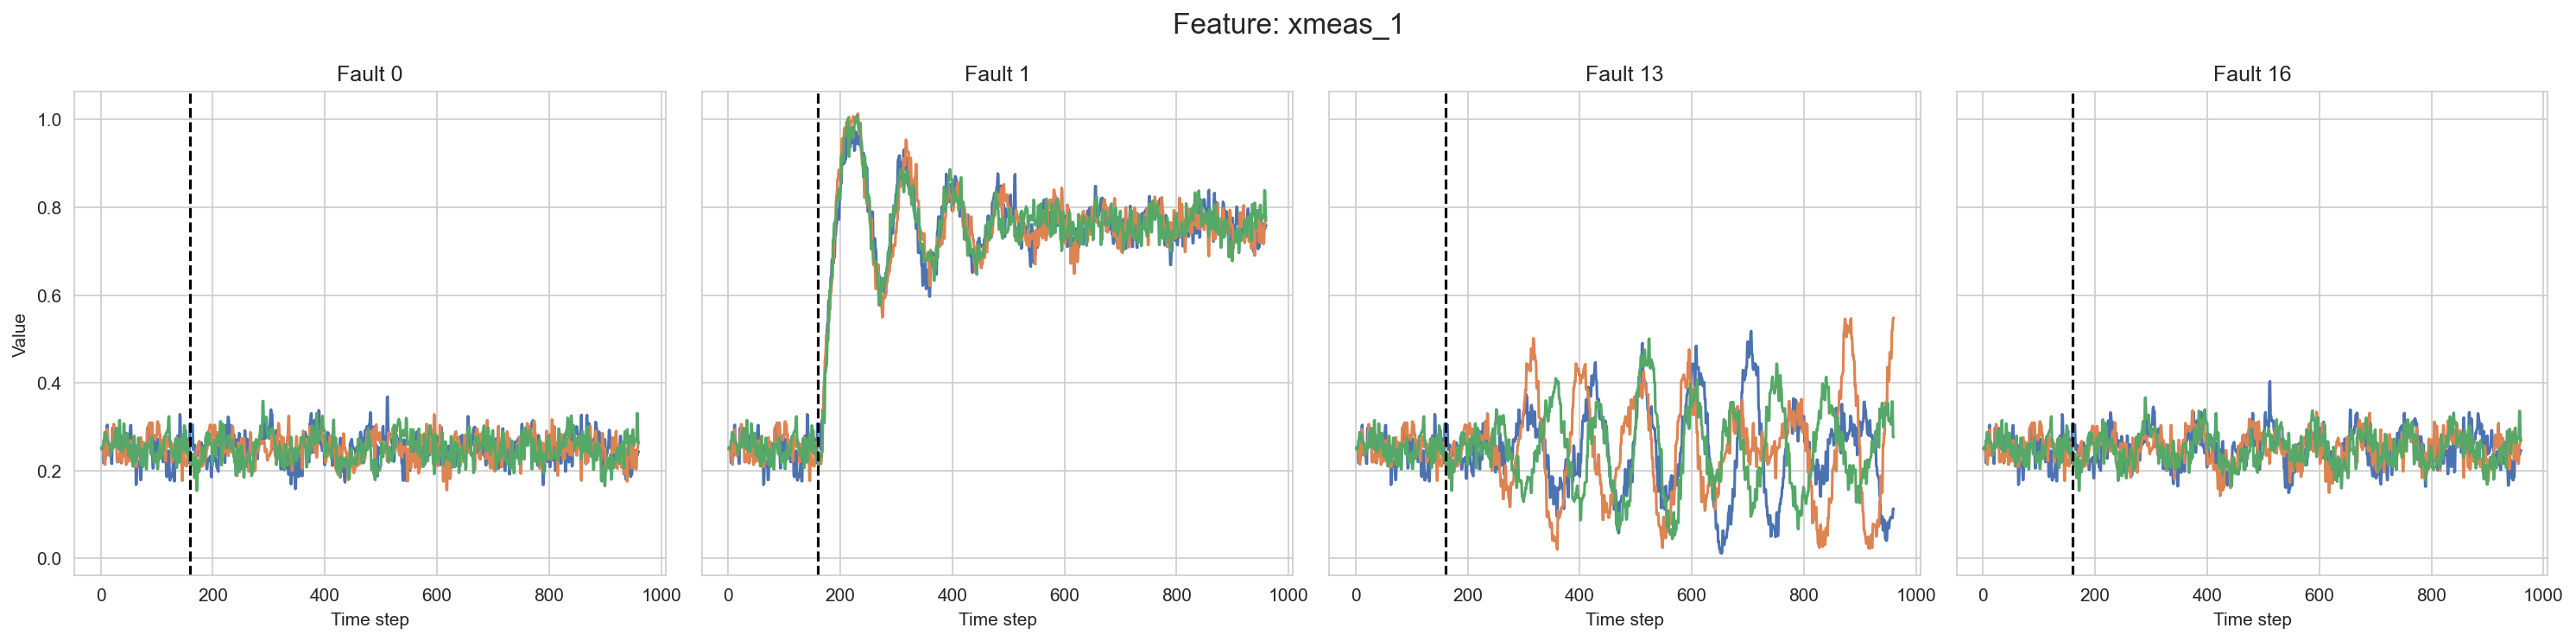

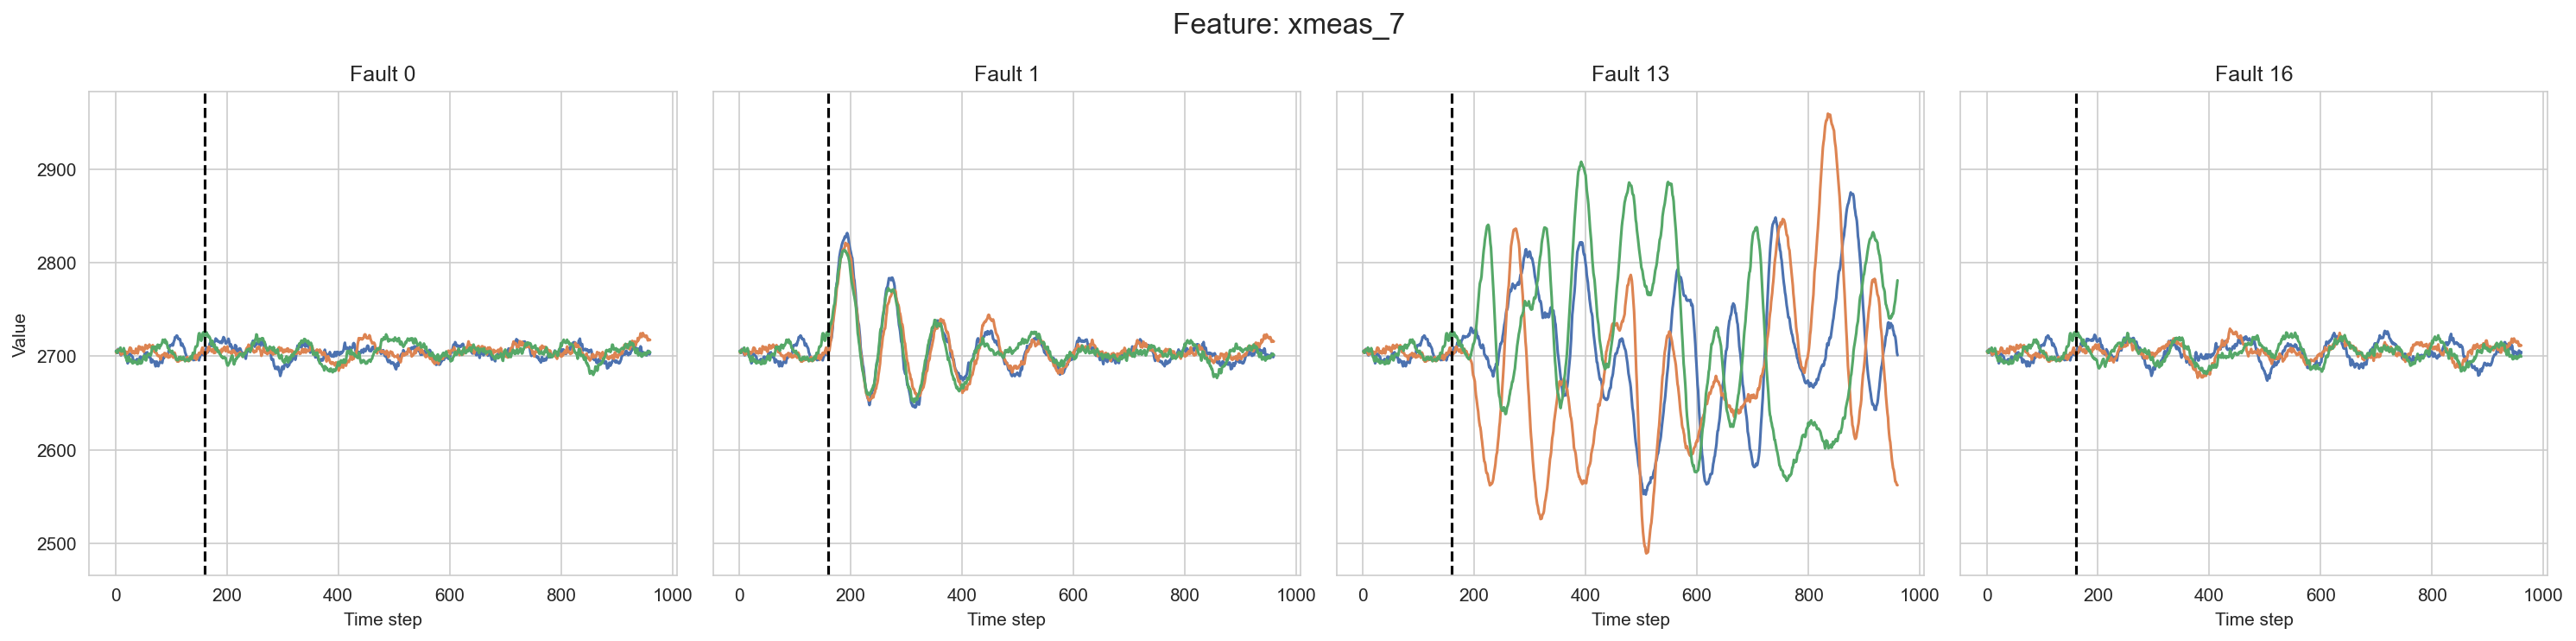

In [24]:
plot_fault_comparison_timeseries(data=df_test, columns=['xmeas_1', 'xmeas_7'], faults=SELECTED_FAULTS, xline=160)

**Critical insight:** In test data, fault injection occurs after time step 160 in all faulty simulations (marked by vertical line), suggesting that the first 160 time steps should be excluded from faulty data during model training to focus on actual anomalous behavior rather than normal startup conditions.

## Distribution Analysis Across Fault Types

Box plots provide another perspective on how features behave under different fault conditions by showing the distribution of values for each fault type.

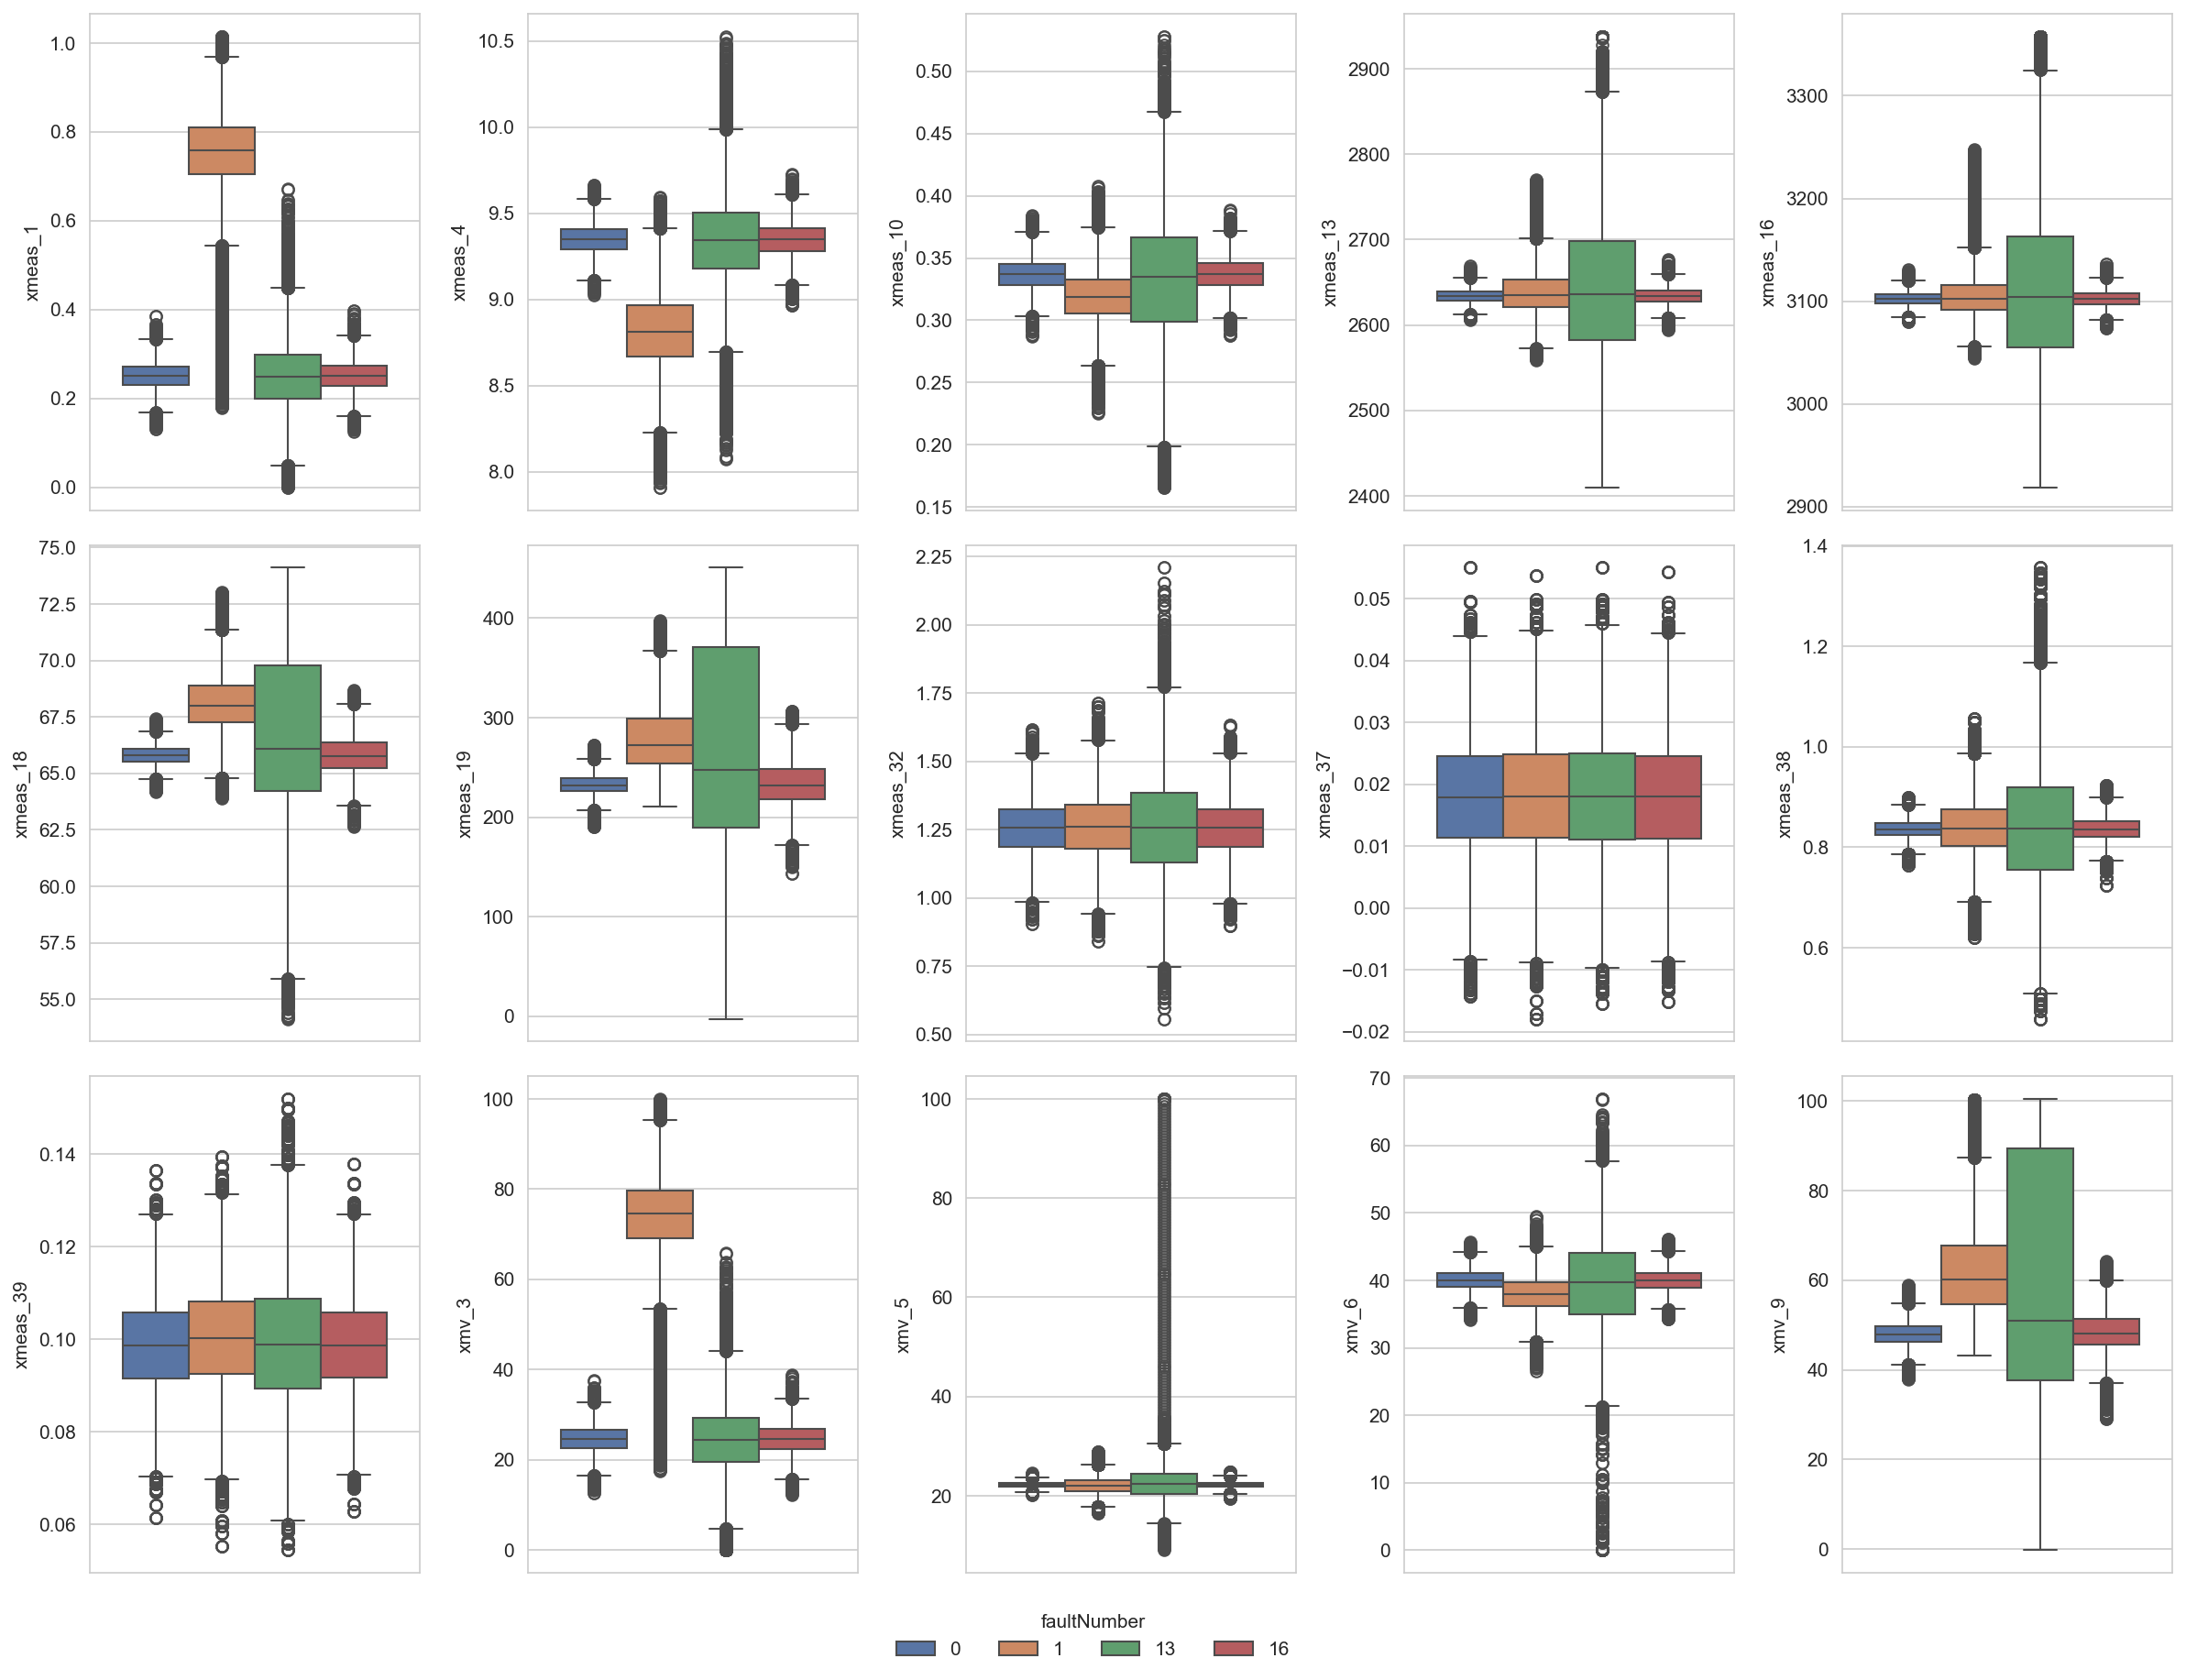

In [25]:
plot_fault_comparison_boxplots(data=df_train_full, columns=SELECTED_FEATURE_COLUMNS, max_cols=5, figsize=(16,12))

### Key Observations

All charts demonstrate dramatic distribution shifts. Features with clear distribution separation will likely perform well in simple statistical models.

**Interesting Anomaly:**
Despite being identified as highly important in both mutual information and variability analyses, `xmeas_37` and `xmeas_39` show only subtle distribution changes between fault types. This suggests that:
- The discriminative power may lie in temporal patterns rather than static distribution differences
- Small but consistent shifts in this feature may still be highly informative for classification
- The feature's importance might emerge from interactions with other variables


## Correlation Analysis Across Fault Types

Correlation matrices reveal how relationships between features change under different fault conditions, which can indicate disrupted process interactions.

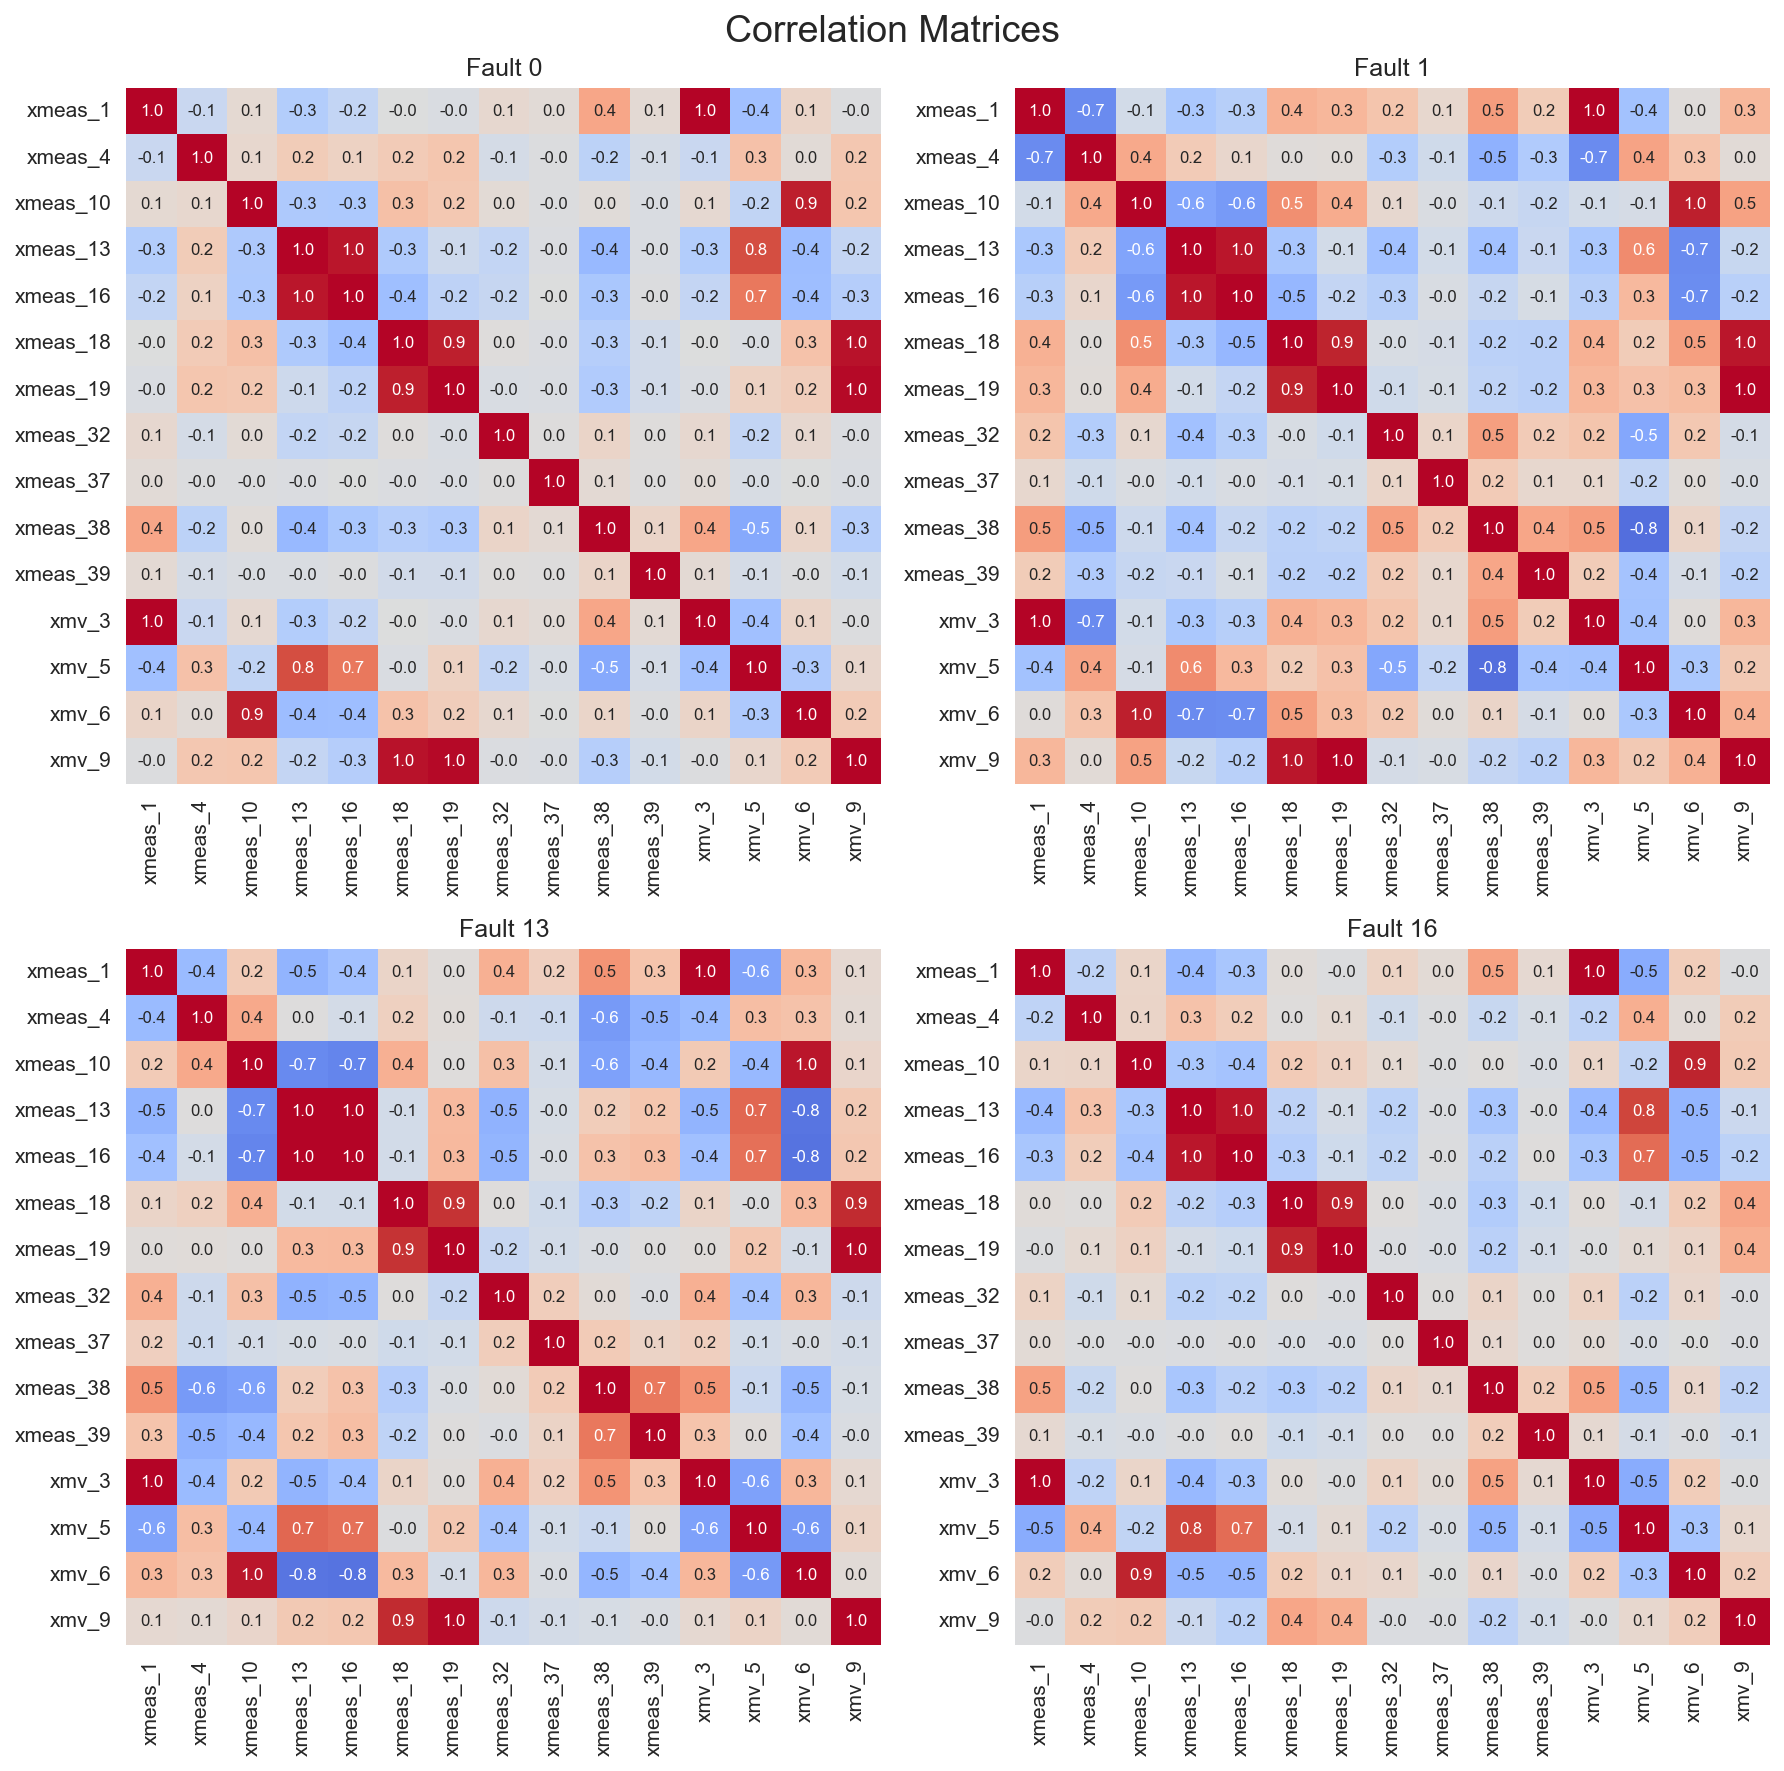

In [26]:
plot_correlation_matrix(
    data=df_train_full,
    columns=SELECTED_FEATURE_COLUMNS,
    split_by='faultNumber',
    figsize=(12,12),
    prefix_title='Fault',
)

**Key Observations:**
- Fault 1 shows the strongest correlation changes compared to normal operation, with many variables becoming highly correlated 
- Normal operation (Fault 0) and Fault 16 have similar correlation patterns, making Fault 16 harder to detect through correlation analysis alone

## Export Key Features

In [29]:
joblib.dump(SELECTED_FEATURE_COLUMNS, '../models/selected_features.pkl');

# Summary

Exploratory analysis revealed several key insights about fault detection in the Tennessee Eastman Process:

**Dataset Characteristics:**
- Clean dataset with 55 features and no missing values
- Selected fault types (1, 13, 16) represent different failure categories: equipment malfunction, process drift, and gradual degradation

**Feature Analysis Results:**
- **Variability analysis** identified fault-specific patterns, with some features showing high variability for particular fault types
- **Mutual information** revealed `xmeas_37` and `xmeas_38` as most informative for general fault detection
- **Time series patterns - critical insight:** fault injection occurs after time step 20 (train data) and after time step 160 (test data) in all faulty simulations, indicating that early time steps in faulty data represent normal operation and should be handled carefully during training

**Distribution and Correlation Insights:**
- Features exhibit different distribution shifts across fault types, with some showing dramatic changes while others remain subtle
- **Correlation disruption** varies by fault type: Fault 1 creates the strongest relationship changes, while Fault 16 maintains patterns similar to normal operation

**Key Finding:**
The analysis confirmed that different fault types require different detection approaches - some are easily identifiable through statistical changes, while others (like Fault 16) need more sophisticated methods to capture subtle temporal patterns.


**Implications for Modeling:**
Both individual feature importance and temporal relationships will be crucial for effective anomaly detection, justifying our multi-algorithm approach in the modeling phase.